Notebook to plot the metrics

# Import Libraries

In [1]:
#import libraries
import numpy as np
import os
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import euclidean

In [2]:
try:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  import sys
  path_to_project = '/content/drive/MyDrive/FairAlgorithm'
  sys.path.append(path_to_project)
  !sudo apt install libcairo2-dev pkg-config python3-dev
  IN_COLAB = True
except:
  IN_COLAB = False

Mounted at /content/drive
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libcairo2-dev is already the newest version (1.16.0-5ubuntu2).
pkg-config is already the newest version (0.29.2-1ubuntu3).
python3-dev is already the newest version (3.10.6-1~22.04.1).
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 47 not upgraded.


# Configure Notebook

In [3]:
dataset_list = ['diabetes-women'] #options: "diabetes-women", "sepsis", 'aids', "myocardial-infarction", 'alzheimer-disease', "diabetes-prediction", "stroke-prediction"
dataset_name = 'diabetes-women'
sensible_attribute = 'AgeCategory'

In [4]:
from source.utils.config import *
print(datasets_config)


dataset_config = datasets_config[dataset_name]
ignore_cols = dataset_config['ignore_cols']
target_variable = dataset_config['target_variable']
target_variable_labels = dataset_config['target_variable_labels']
sensible_attributes = dataset_config['sensible_attributes']
default_mappings = dataset_config.get('default_mappings', {})
metrics = fairness_catalogue
perf_metrics = ['accuracy', 'precision', 'recall', 'f1_score']

{'diabetes-women': {'ignore_cols': ['Age'], 'target_variable': 'Outcome', 'target_variable_labels': [1, 0], 'sensible_attributes': ['AgeCategory'], 'default_mappings': {'label_maps': [{1.0: 'Diabetic', 0.0: 'NonDiabetic'}], 'protected_attribute_maps': [{1.0: 'Adult', 0.0: 'Young'}]}}, 'sepsis': {'ignore_cols': [], 'target_variable': 'Mortality', 'target_variable_labels': [1, 0], 'sensible_attributes': ['Gender_cat', 'Age_cat'], 'default_mappings': {}}, 'aids': {'ignore_cols': [], 'target_variable': 'cid', 'target_variable_labels': [1, 0], 'sensible_attributes': ['homo_cat', 'race_cat', 'age_cat'], 'default_mappings': {}}, 'myocardial-infarction': {'ignore_cols': [], 'target_variable': 'LET_IS_cat', 'target_variable_labels': [1, 0], 'sensible_attributes': ['SEX'], 'default_mappings': {'label_maps': [{1: 'Complication', 0: 'No Alzheimer'}], 'protected_attribute_maps': [{0: 'Female', 1: 'Male'}]}}, 'alzheimer-disease': {'ignore_cols': [], 'target_variable': 'Diagnosis', 'target_variable_l

# Load Metrics

In [5]:
# Load the metrics results
def load_metrics(dataset_name, sensible_attribute, mitigation):
  load_path = path_to_project + '/measurements/metrics-{}-{}-{}.p'.format(dataset_name, sensible_attribute, mitigation)
  with open(load_path, 'rb') as fp:
      mitigation_metrics = pickle.load(fp)
  return mitigation_metrics

def load_performance_metrics(dataset_name, sensible_attribute, mitigation):
  load_path = path_to_project + '/measurements/performance_metrics-{}-{}-{}.p'.format(dataset_name, sensible_attribute, mitigation)
  with open(load_path, 'rb') as fp:
      performance_metrics = pickle.load(fp)
  return performance_metrics

def load_original_performance_metrics(dataset_name, sensible_attribute):
  load_path = path_to_project + '/measurements/performance_metrics-{}-{}-original.p'.format(dataset_name, sensible_attribute)
  with open(load_path, 'rb') as fp:
      performance_metrics = pickle.load(fp)
  return performance_metrics

def load_original_metrics(dataset, sensible_attribute):
  load_path = path_to_project + '/measurements/metrics-{}-{}-original.p'.format(dataset, sensible_attribute)
  with open(load_path, 'rb') as fp:
      original_metrics = pickle.load(fp)
  return original_metrics

In [6]:
def load_array_metrics(dataset_list, all_mitigations, preprocessing_mitigation_list, inprocessing_mitigation_list, postprocessing_mitigation_list):
  overall_metrics = {}
  preprocessing_metrics = {}
  inprocessing_metrics = {}
  postprocessing_metrics = {}
  performance_metrics= {}

  # Load metrics for all datasets and mitigations
  for dataset in dataset_list:
    for sensible_attribute in sensible_attributes:
      ds_metrics = {}
      pre_metrics = {}
      in_metrics = {}
      post_metrics = {}
      perf_metrics = {}
      print('all')
      for mitigation in all_mitigations:
        ds_metrics[mitigation] = load_metrics(dataset, sensible_attribute, mitigation)
        perf_metrics[mitigation] = load_performance_metrics(dataset, sensible_attribute, mitigation)
      print('pre')
      for mitigation in preprocessing_mitigation_list:
        pre_metrics[mitigation] = load_metrics(dataset, sensible_attribute, mitigation)
      print('in')
      for mitigation in inprocessing_mitigation_list:
        in_metrics[mitigation] = load_metrics(dataset, sensible_attribute, mitigation)
      print('post')
      for mitigation in postprocessing_mitigation_list:
        post_metrics[mitigation] = load_metrics(dataset, sensible_attribute, mitigation)
      overall_metrics[dataset] = ds_metrics
      preprocessing_metrics[dataset] = pre_metrics
      inprocessing_metrics[dataset] = in_metrics
      postprocessing_metrics[dataset] = post_metrics
      performance_metrics[dataset] = perf_metrics
      print('metrics mitigation loaded')
      original_metrics = load_original_metrics(dataset, sensible_attribute)

      overall_metrics[dataset]['original'] = original_metrics
      preprocessing_metrics[dataset]['original'] = original_metrics
      postprocessing_metrics[dataset]['original'] = original_metrics
      performance_metrics[dataset]['original'] = load_original_performance_metrics(dataset, sensible_attribute)
      for m in models:
        print(m)
        orig_metrics = {}
        orig_metrics['division'] = original_metrics['division'][m]
        orig_metrics['subtraction'] = original_metrics['subtraction'][m]
        inprocessing_metrics[dataset]['orig-'+str(m)] = orig_metrics
        #inprocessing_metrics[dataset][m]['division'] = original_metrics['division'][m]
        #inprocessing_metrics[dataset][m]['subtraction'] = original_metrics['subtraction'][m]
      print('original metrics  loaded')

  return overall_metrics, preprocessing_metrics, inprocessing_metrics, postprocessing_metrics, performance_metrics


# Plotting functions
Grouped bar chart with full results for one mitigation.

In [7]:
def grouped_bar(metrics_dict, mitigation_list, comparison, model, mitigation_category):
  bars_per_group = len(metrics)
  num_groups = len(mitigation_list)

  data = []
  for mitigation in mitigation_list:
    l = []
    for metric in metrics:
      l.append(metrics_dict[mitigation][comparison][model][metric][0])
    data.append(l)

  print(data)
  data = np.asarray(data)
  data = data.reshape((num_groups, bars_per_group))

  # Set up bar positions
  bar_width = 0.1
  bar_positions = np.arange(bars_per_group)

  plt.figure(figsize=(12, 6))

  # Plot the vertical bar plot
  for i in range(num_groups):
      plt.bar(bar_positions + i*bar_width,
              data[i],
              width=bar_width,
              label=mitigation_list[i])

  # Add red threshold lines
  threshold_high = 0.15
  threshold_low = -0.15
  plt.axhline(y=threshold_high, color='red', linestyle='--', label='Threshold (+0.15)')
  plt.axhline(y=threshold_low, color='red', linestyle='--', label='Threshold (-0.15)')

  # Add labels and title
  plt.xlabel('Fairness Metrics')
  plt.ylabel('Fairness Metric Values')
  plt.title(dataset_name+' '+model+' '+comparison+' '+mitigation_category)

  plt.xticks(bar_positions + bar_width, metrics, rotation=45, ha='right')
  plt.legend()

  model_no_spaces = model.replace(" ", "")
  configuration = f"{dataset_name}-{sensible_attribute}"
  file_name = f"{mitigation_category}-{model_no_spaces}-{comparison}.png"

  path = os.path.join(path_to_project,'plots', configuration, file_name )
  plt.savefig(path, bbox_inches="tight")

  # Show the plot
  plt.show()

In [8]:
def perf_grouped_bar(metrics_dict, mitigation_list, model, mitigation_category):
  bars_per_group = len(perf_metrics)
  num_groups = len(mitigation_list)

  data = []
  for mitigation in mitigation_list:
    l = []
    for metric in perf_metrics:
      l.append(metrics_dict[mitigation][metric][model][0])
    data.append(l)

  data = np.asarray(data)
  data = data.reshape((num_groups, bars_per_group))

  # Set up bar positions
  bar_width = 0.1
  bar_positions = np.arange(bars_per_group)

  plt.figure(figsize=(12, 6))

  # Plot the vertical bar plot
  for i in range(num_groups):
      plt.bar(bar_positions + i*bar_width,
              data[i],
              width=bar_width,
              label=mitigation_list[i])

  # Add labels and title
  plt.xlabel('Perfomance Metrics')
  plt.ylabel('Perfomance Values')
  plt.title(dataset_name+' '+model+' '+mitigation_category)

  plt.xticks(bar_positions + bar_width, perf_metrics, rotation=45, ha='right')
  plt.legend()

  model_no_spaces = model.replace(" ", "")
  configuration = f"{dataset_name}-{sensible_attribute}/performance"
  file_name = f"{mitigation_category}-{model_no_spaces}.png"

  path = os.path.join(path_to_project,'plots', configuration, file_name )
  plt.savefig(path, bbox_inches="tight")

  # Show the plot
  plt.show()

In [9]:
def grouped_bar_no_model(metrics_dict, mitigation_list, comparison, mitigation_category):
  bars_per_group = len(metrics)
  num_groups = len(mitigation_list)

  data = []
  for mitigation in mitigation_list:
    l = []
    for metric in metrics:
      l.append(metrics_dict[mitigation][comparison][metric][0])
    data.append(l)

  data = np.asarray(data)
  data = data.reshape((num_groups, bars_per_group))

  # Set up bar positions
  bar_width = 0.1
  bar_positions = np.arange(bars_per_group)

  plt.figure(figsize=(12, 6))

  # Plot the vertical bar plot
  for i in range(num_groups):
      plt.bar(bar_positions + i*bar_width,
              data[i],
              width=bar_width,
              label=mitigation_list[i])
  # Add red threshold lines
  threshold_high = 0.15
  threshold_low = -0.15
  plt.axhline(y=threshold_high, color='red', linestyle='--', label='Threshold (+0.15)')
  plt.axhline(y=threshold_low, color='red', linestyle='--', label='Threshold (-0.15)')

  # Add labels and title
  plt.xlabel('Fairness Metrics')
  plt.ylabel('Fairness Metric Values')
  plt.title(dataset_name+' '+comparison+' '+mitigation_category)

  plt.xticks(bar_positions + bar_width, metrics, rotation=45, ha='right')
  plt.legend()

  configuration = f"{dataset_name}-{sensible_attribute}"
  file_name = f"{mitigation_category}-{comparison}.png"
  path = os.path.join(path_to_project,'plots',configuration, file_name )
  plt.savefig(path,  bbox_inches="tight")

  # Show the plot
  plt.show()

In [10]:
def perf_grouped_bar_no_model(metrics_dict, mitigation_list, mitigation_category):
  bars_per_group = len(perf_metrics)
  num_groups = len(mitigation_list)

  data = []
  for mitigation in mitigation_list:
    l = []
    for metric in perf_metrics:
      l.append(metrics_dict[mitigation][metric][0])
    data.append(l)

  data = np.asarray(data)
  data = data.reshape((num_groups, bars_per_group))

  # Set up bar positions
  bar_width = 0.1
  bar_positions = np.arange(bars_per_group)

  plt.figure(figsize=(12, 6))

  # Plot the vertical bar plot
  for i in range(num_groups):
      plt.bar(bar_positions + i*bar_width,
              data[i],
              width=bar_width,
              label=mitigation_list[i])
  # Add red threshold lines
  threshold_high = 0.15
  threshold_low = -0.15
  plt.axhline(y=threshold_high, color='red', linestyle='--', label='Threshold (+0.15)')
  plt.axhline(y=threshold_low, color='red', linestyle='--', label='Threshold (-0.15)')

  # Add labels and title
  plt.xlabel('Performance Metrics')
  plt.ylabel('Performance Metric Values')
  plt.title(dataset_name+' '+mitigation_category)

  plt.xticks(bar_positions + bar_width, perf_metrics, rotation=45, ha='right')
  plt.legend()

  configuration = f"{dataset_name}-{sensible_attribute}/performance"
  file_name = f"{mitigation_category}.png"
  path = os.path.join(path_to_project,'plots',configuration, file_name )
  plt.savefig(path,  bbox_inches="tight")

  # Show the plot
  plt.show()

In [11]:
def grouped_bar_given_model(metrics_dict, mitigation_list):
  bars_per_group = len(metrics)
  num_groups = len(mitigation_list)

  data = []
  for mitigation in mitigation_list:
    l = []
    for metric in metrics:
      l.append(metrics_dict[mitigation][metric][0])
    data.append(l)

  data = np.asarray(data)
  data = data.reshape((num_groups, bars_per_group))

  # Set up bar positions
  bar_width = 0.1
  bar_positions = np.arange(bars_per_group)

  plt.figure(figsize=(12, 6))

  # Plot the vertical bar plot
  for i in range(num_groups):
      plt.bar(bar_positions + i*bar_width,
              data[i],
              width=bar_width,
              label=mitigation_list[i])
  # Add red threshold lines
  threshold_high = 0.15
  threshold_low = -0.15
  plt.axhline(y=threshold_high, color='red', linestyle='--', label='Threshold (+0.15)')
  plt.axhline(y=threshold_low, color='red', linestyle='--', label='Threshold (-0.15)')

  # Add labels and title
  plt.xlabel('Bar Group')
  plt.ylabel('Values')
  plt.title('Vertical Bar Plot')

  plt.xticks(bar_positions + bar_width, metrics, rotation=45, ha='right')
  plt.legend()

  # Show the plot
  plt.show()

# Table function

In [14]:
def data_framing(dictionary, dataset, comparison, model, mitigation_list):
  # Define the columns for your DataFrame
  columns = ['Mitigation'] + metrics

  # Create an empty DataFrame with the specified columns
  data = pd.DataFrame(columns=columns)

  for mitigation in mitigation_list:
    l = []
    l.append(mitigation)
    for metric in metrics:
      l.append(dictionary[dataset][mitigation][comparison][model][metric][0])
    row_df = pd.DataFrame([l], columns=columns)
    data = pd.concat([data, row_df], ignore_index=True)

  data.set_index('Mitigation', inplace=True)
  return data

In [15]:
def perf_data_framing(dictionary, dataset, model, mitigation_list):
  # Define the columns for your DataFrame
  columns = ['Mitigation'] + perf_metrics

  # Create an empty DataFrame with the specified columns
  data = pd.DataFrame(columns=columns)

  for mitigation in mitigation_list:
    l = []
    l.append(mitigation)
    for metric in perf_metrics:
      if model is not None:
        l.append(f"{dictionary[dataset][mitigation][metric][model][0]:.3f}+/-{dictionary[dataset][mitigation][metric][model][1]:.3f}")
      else:
        l.append(f"{dictionary[dataset][mitigation][metric][0]:.3f}+/-{dictionary[dataset][mitigation][metric][1]:.3f}")
    row_df = pd.DataFrame([l], columns=columns)
    data = pd.concat([data, row_df], ignore_index=True)

  data.set_index('Mitigation', inplace=True)
  return data

#Load metrics

In [16]:
for sensible_attribute in sensible_attributes:
  overall_metrics, preprocessing_metrics, inprocessing_metrics, postprocessing_metrics, performance_metrics = load_array_metrics(dataset_list, all_mitigations, preprocessing_mitigation_list, inprocessing_mitigation_list, postprocessing_mitigation_list)

all
pre
in
post
metrics mitigation loaded
Logistic Regression
Decision Tree
Bagging
Random Forest
Extremely Randomized Trees
Ada Boost
original metrics  loaded


In [17]:
print(overall_metrics)

{'diabetes-women': {'fl-cr': {'division': {'Logistic Regression': {'GroupFairness': [0.4485640250147889, 0.0982432939984986], 'PredictiveParity': [0.2543328944428689, 0.1660134763185997], 'PredictiveEquality': [0.4383333333333333, 0.6231860095261573], 'EqualOpportunity': [-0.8981180223285486, 0.15740107448868537], 'EqualizedOdds': [0.7102941176470589, 0.2738457284250257], 'ConditionalUseAccuracyEquality': [0.5731531279178338, 0.32602709201233737], 'OverallAccuracyEquality': [-1.0, 0.0], 'TreatmentEquality': [-0.8324999999999999, 0.27614534216604125], 'FORParity': [-0.5125, 0.7993161139374084], 'FN': [-0.8504223521767381, 0.23583823166850762], 'FP': [-0.42579168063346523, 0.346304425171401]}, 'Decision Tree': {'GroupFairness': [0.5024722885605, 0.17462656537572815], 'PredictiveParity': [0.26523617643237546, 0.1317491765432381], 'PredictiveEquality': [0.7066369047619048, 0.40852596043934725], 'EqualOpportunity': [-0.5721902157992383, 0.16998342966184535], 'EqualizedOdds': [0.747849025974

In [18]:
print(preprocessing_metrics)
print("mean:"+str(preprocessing_metrics['diabetes-women']['aif360-di']['division']['Logistic Regression']['GroupFairness'][0]))
print("std dev:"+str(preprocessing_metrics['diabetes-women']['aif360-di']['division']['Logistic Regression']['GroupFairness'][1]))

{'diabetes-women': {'fl-cr': {'division': {'Logistic Regression': {'GroupFairness': [0.4485640250147889, 0.0982432939984986], 'PredictiveParity': [0.2543328944428689, 0.1660134763185997], 'PredictiveEquality': [0.4383333333333333, 0.6231860095261573], 'EqualOpportunity': [-0.8981180223285486, 0.15740107448868537], 'EqualizedOdds': [0.7102941176470589, 0.2738457284250257], 'ConditionalUseAccuracyEquality': [0.5731531279178338, 0.32602709201233737], 'OverallAccuracyEquality': [-1.0, 0.0], 'TreatmentEquality': [-0.8324999999999999, 0.27614534216604125], 'FORParity': [-0.5125, 0.7993161139374084], 'FN': [-0.8504223521767381, 0.23583823166850762], 'FP': [-0.42579168063346523, 0.346304425171401]}, 'Decision Tree': {'GroupFairness': [0.5024722885605, 0.17462656537572815], 'PredictiveParity': [0.26523617643237546, 0.1317491765432381], 'PredictiveEquality': [0.7066369047619048, 0.40852596043934725], 'EqualOpportunity': [-0.5721902157992383, 0.16998342966184535], 'EqualizedOdds': [0.747849025974

# Preprocessing results

In [15]:
print(preprocessing_metrics["diabetes-women"])

{'fl-cr': {'division': {'Logistic Regression': {'GroupFairness': [0.4485640250147889, 0.0982432939984986], 'PredictiveParity': [0.2543328944428689, 0.1660134763185997], 'PredictiveEquality': [0.4383333333333333, 0.6231860095261573], 'EqualOpportunity': [-0.8981180223285486, 0.15740107448868537], 'EqualizedOdds': [0.7102941176470589, 0.2738457284250257], 'ConditionalUseAccuracyEquality': [0.5731531279178338, 0.32602709201233737], 'OverallAccuracyEquality': [-1.0, 0.0], 'TreatmentEquality': [-0.8324999999999999, 0.27614534216604125], 'FORParity': [-0.5125, 0.7993161139374084], 'FN': [-0.8504223521767381, 0.23583823166850762], 'FP': [-0.42579168063346523, 0.346304425171401]}, 'Decision Tree': {'GroupFairness': [0.5024722885605, 0.17462656537572815], 'PredictiveParity': [0.26523617643237546, 0.1317491765432381], 'PredictiveEquality': [0.7066369047619048, 0.40852596043934725], 'EqualOpportunity': [-0.5721902157992383, 0.16998342966184535], 'EqualizedOdds': [0.7478490259740259, 0.32779650812

In [16]:
preprocessing_mitigation_list.insert(0, 'original')

## Performance metrics

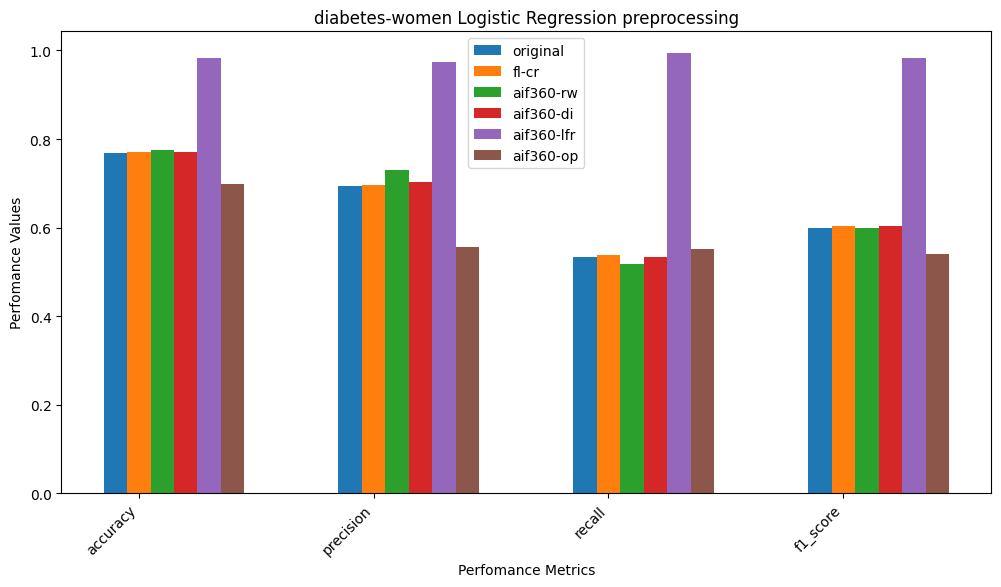

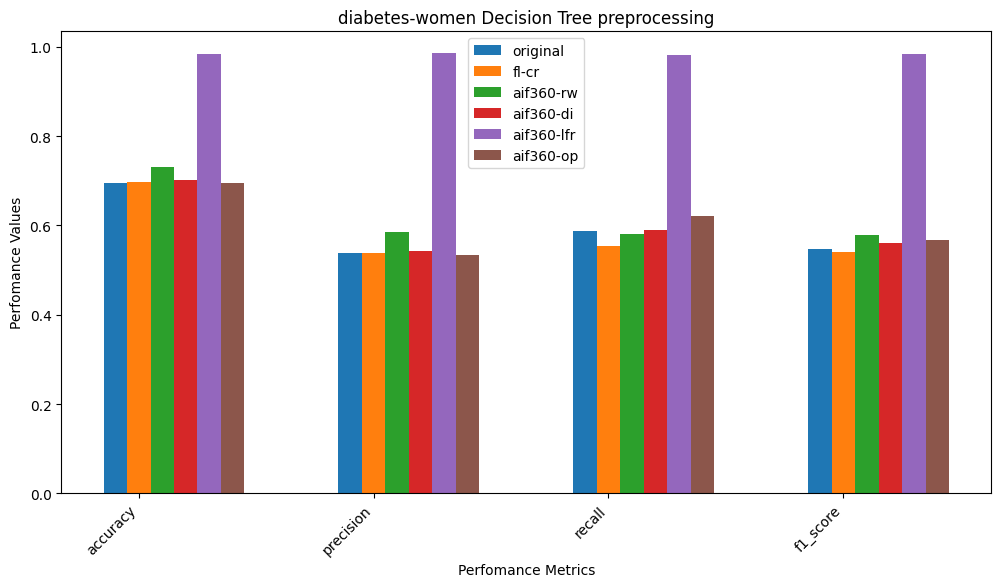

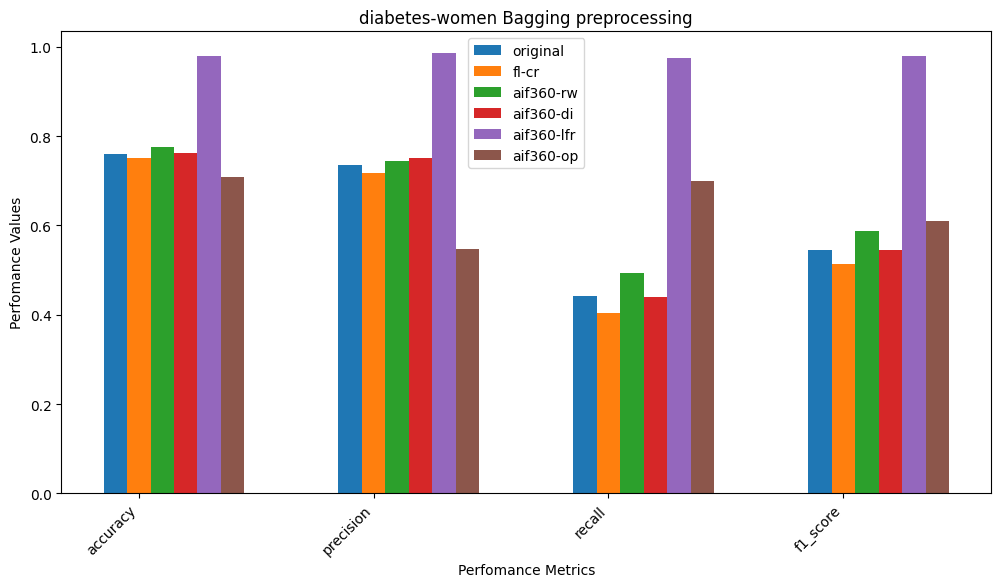

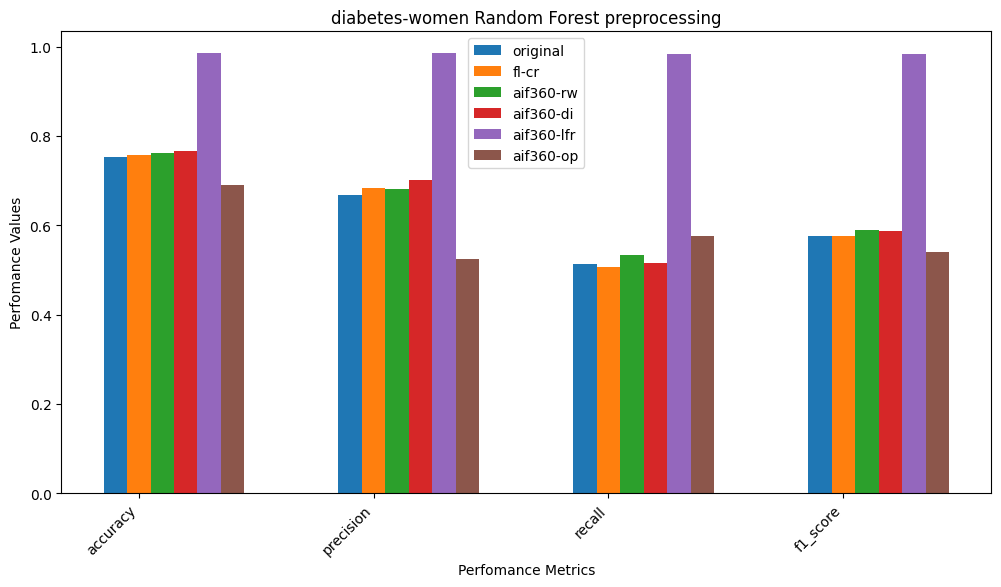

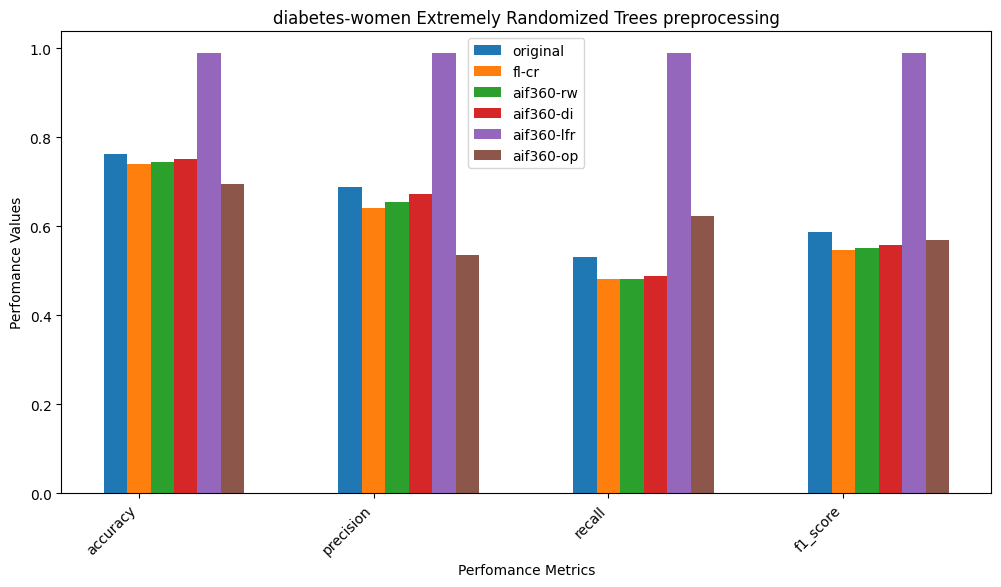

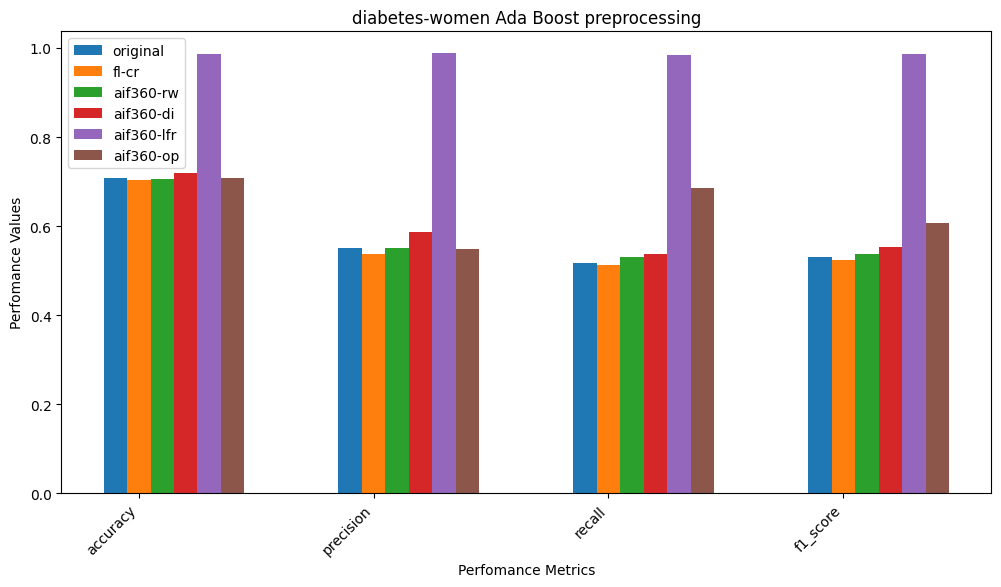

In [17]:
for m in models:
  perf_grouped_bar(performance_metrics["diabetes-women"], preprocessing_mitigation_list, m, 'preprocessing')

In [44]:
perf_data_framing(performance_metrics, 'diabetes-women', "Logistic Regression", preprocessing_mitigation_list)

,accuracy,precision,recall,f1_score
Mitigation,,,,
original,0.769+/-0.046,0.693+/-0.083,0.533+/-0.037,0.600+/-0.045
fl-cr,0.772+/-0.045,0.697+/-0.084,0.537+/-0.045,0.604+/-0.052
aif360-rw,0.776+/-0.049,0.730+/-0.081,0.517+/-0.072,0.600+/-0.055
aif360-di,0.772+/-0.049,0.703+/-0.090,0.533+/-0.051,0.603+/-0.055
aif360-lfr,0.984+/-0.017,0.974+/-0.027,0.993+/-0.013,0.983+/-0.018
aif360-op,0.699+/-0.060,0.555+/-0.117,0.551+/-0.147,0.541+/-0.103


### Diabetes-women, all pre-processing techniques, division, all ML models

[[0.4605894995402635, 0.251475751585726, 0.4883333333333333, -0.8981180223285486, 0.7602941176470589, 0.5760102707749767, -1.0, -0.8324999999999999, -0.5125, -0.8504223521767381, -0.396570901412686], [0.4485640250147889, 0.2543328944428689, 0.4383333333333333, -0.8981180223285486, 0.7102941176470589, 0.5731531279178338, -1.0, -0.8324999999999999, -0.5125, -0.8504223521767381, -0.42579168063346523], [0.21072254146229322, 0.312664836487777, -0.15858585858585858, -0.1657758031442242, 0.5164141414141414, 0.32467311806127597, -1.0, 0.1, 0.29333333333333333, 0.06543922558922559, -0.6827423037881444], [0.43899281963713194, 0.25743165292552816, 0.42055555555555557, -0.8829665071770336, 0.6925163398692812, 0.5628492063492063, -1.0, -0.7825, -0.5125, -0.8257309941520468, -0.4323760427733829], [-0.22383016252047527, -0.01615384615384614, 0.8, 0.2, 1.0, 0.009411764705882364, -1.0, 0.8, 0.2, 0.2, 0.8], [-0.10050660377727297, 0.08391534248035891, -0.20577396985730317, 0.3033895568187012, 0.089878436

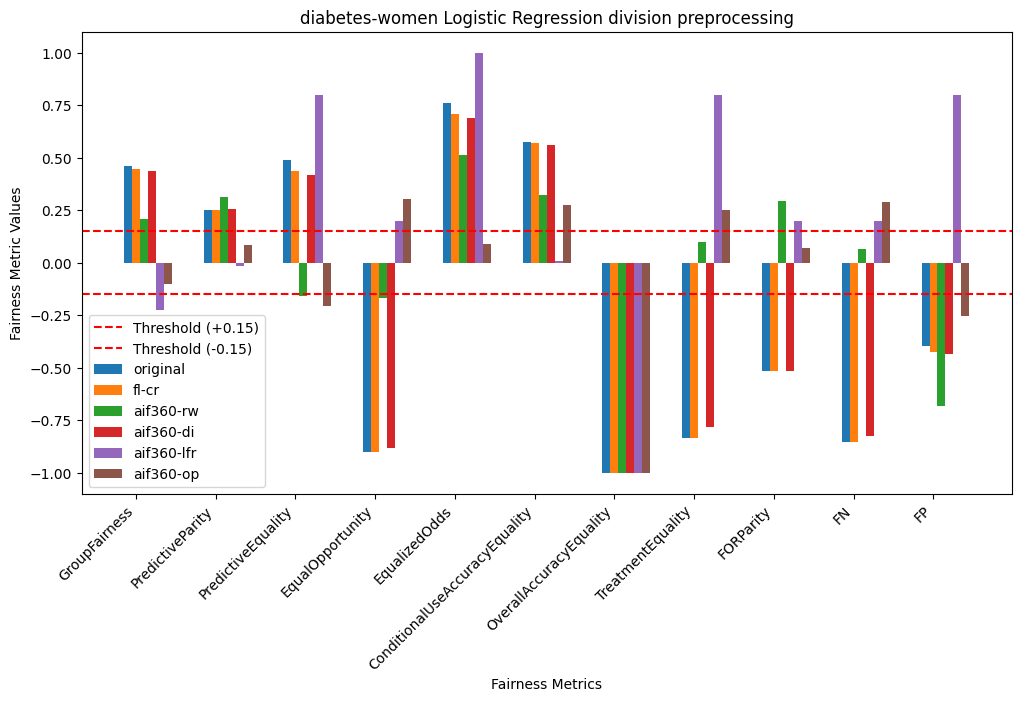

[[0.33989108464399215, 0.3438969373022759, 0.343015873015873, -0.35415698336750967, 0.5994817927170868, 0.48677124086985674, -1.0, 0.3244318181818182, 0.39455266955266954, -0.041251729437637774, -0.49518686455132405], [0.5024722885605, 0.26523617643237546, 0.7066369047619048, -0.5721902157992383, 0.7478490259740259, 0.46431020475912116, -1.0, 0.2348809523809523, 0.6595238095238096, -0.3628634363498541, -0.3552915036136598], [0.43326869086037834, 0.28225856512400077, 0.2954208754208754, -0.5204199893673579, 0.7443002932167019, 0.25890368858867313, -1.0, -0.3175595238095238, 0.34771164021164025, -0.28143787319390035, -0.4478237525912407], [0.5517780161501222, 0.26467496166257776, 0.3371212121212122, -0.520759474443685, 0.7371212121212122, 0.45551217914066217, -1.0, -0.22484848484848485, 0.5926190476190476, -0.3174418296181171, -0.32104604302821615], [-0.248648897392388, -0.015509843417452106, 0.62, 0.8, 0.82, 0.008125000000000004, -1.0, 0.8, 0.8, 0.8, 0.6962962962962963], [0.073681223970

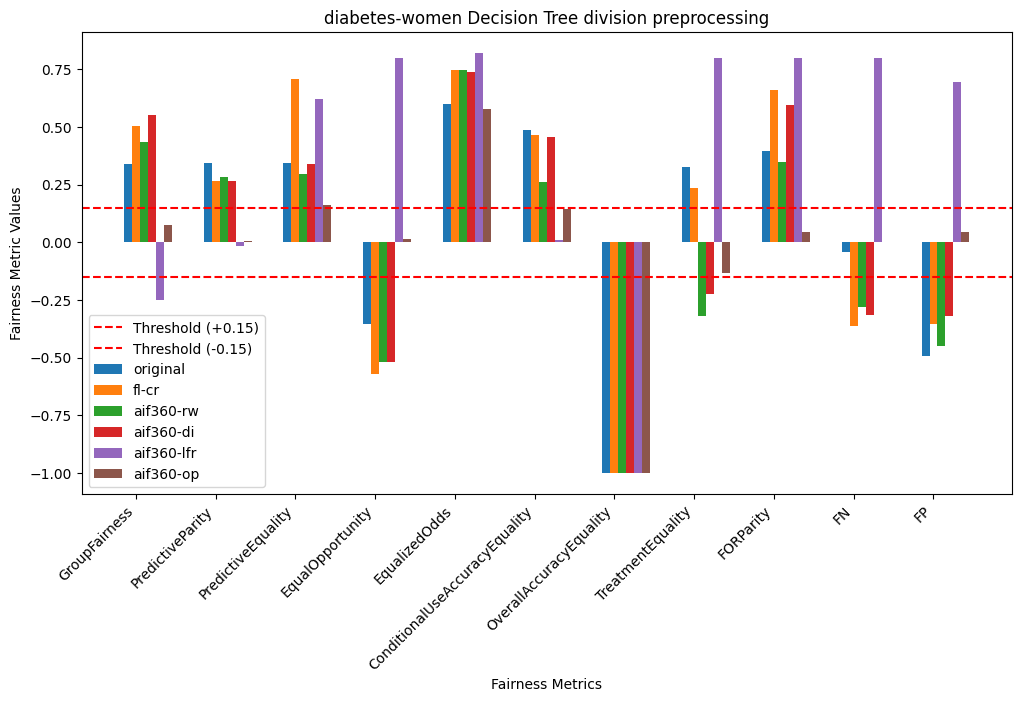

[[0.2605478910819127, 0.31020670684164725, 0.2360479797979798, -0.4488972431077694, 0.5026994569757728, 0.587945678015401, -1.0, -0.18333333333333335, -0.05, -0.31015395894428155, -0.5489289327914115], [0.15179711921572148, 0.37119652090917504, -0.2063973063973064, -0.24075187969924813, 0.28187754740386317, 0.5845457129887528, -1.0, -0.06666666666666668, 0.0, -0.13181818181818183, -0.6898776070185239], [0.20830600405035815, 0.3317558042051042, -0.17642857142857143, -0.436120984278879, 0.280995670995671, 0.4672523447016447, -1.0, -0.011111111111111117, 0.061111111111111116, -0.2932682560370733, -0.6870229557275398], [0.21258783767413378, 0.3130222202054697, -0.045595538720538745, -0.19789473684210526, 0.41788133528265103, 0.5984745668006735, -1.0, -0.06666666666666668, 0.0, -0.13181818181818183, -0.6167084008591861], [-0.21237409318636713, -0.058773448773448776, 1.0, 0.6, 1.0, -0.012299465240641705, -1.0, 1.0, 0.6, 0.6, 1.0], [0.15858142038395764, -0.03655295524626303, 0.259595959595959

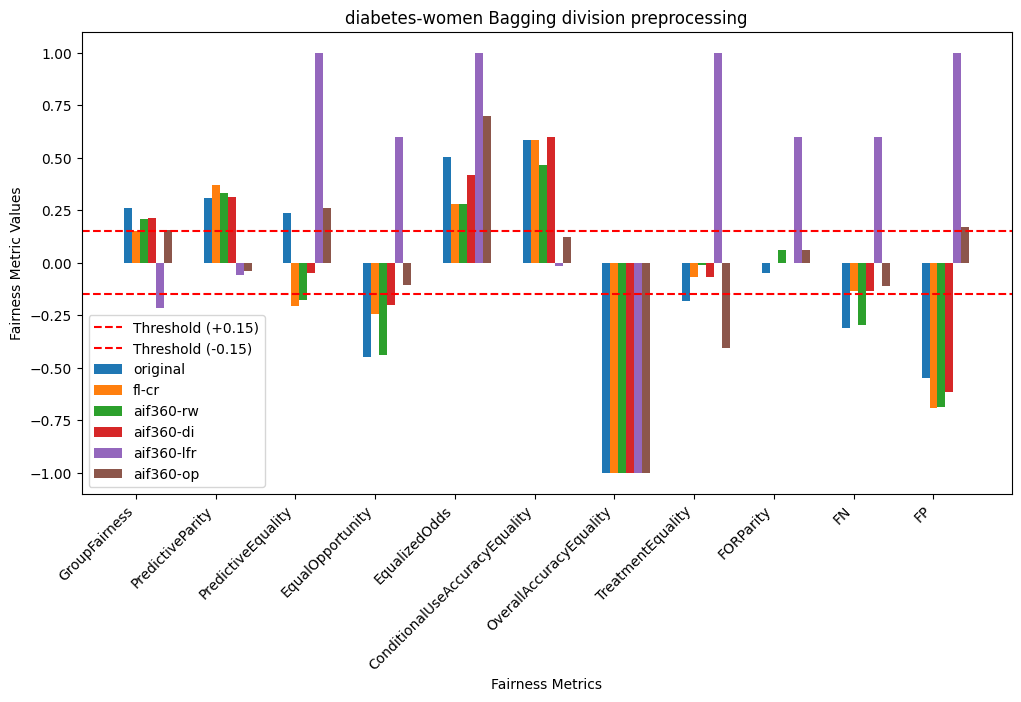

[[0.40169602657997655, 0.27580043819493943, 0.4004960317460318, -0.7846289967342599, 0.6809126984126984, 0.4697357503607503, -1.0, -0.44361111111111107, -0.16354166666666664, -0.6790678488335534, -0.4484646877865893], [0.3905609422319231, 0.2917774585091194, 0.39825757575757575, -0.7736580086580087, 0.6733543417366945, 0.5349042959134505, -1.0, -0.28791666666666665, -0.1875, -0.6606322329120291, -0.40820745530329566], [0.37974520418814084, 0.27364319197815606, 0.36536297036297033, -0.6504567479304322, 0.6386147186147186, 0.5493736400198168, -1.0, 0.02083333333333335, 0.020833333333333325, -0.4953085659462003, -0.43073604787654035], [0.38286641945080974, 0.2684185764358987, 0.44833333333333336, -0.6719062808536493, 0.72875, 0.4924516765513882, -1.0, -0.23888888888888885, 0.16666666666666669, -0.4883718395042673, -0.4323455045509941], [-0.224485101658701, -0.033939393939393936, 0.9384615384615385, 0.6, 0.9384615384615385, -0.012299465240641705, -1.0, 1.0, 0.6, 0.6, 1.0], [0.0259951029768

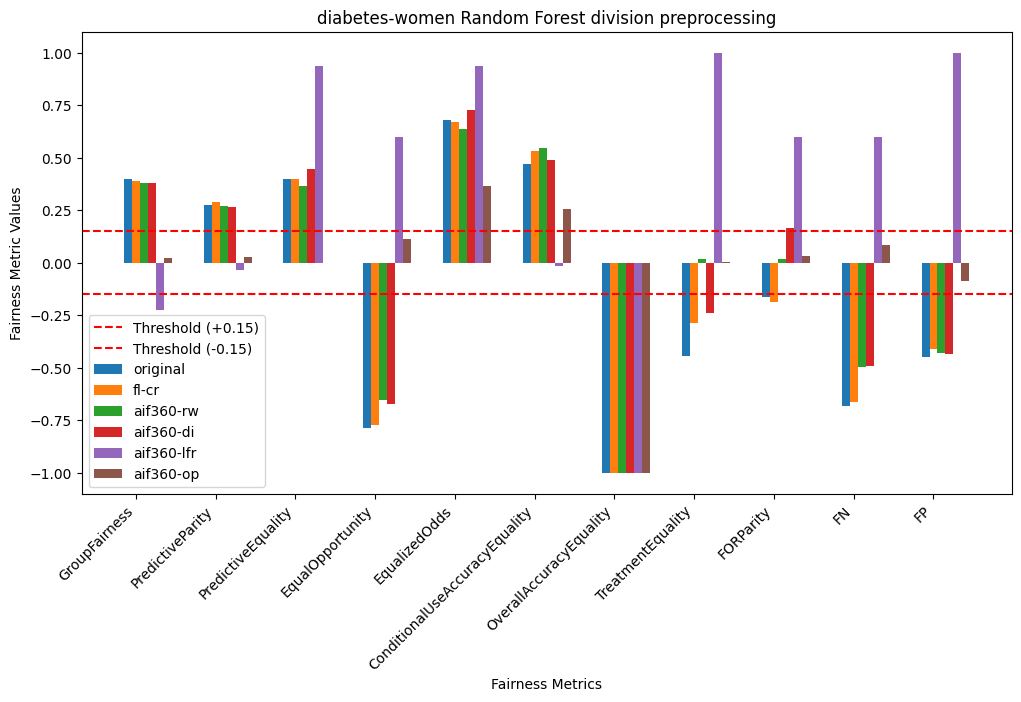

[[0.41883099962087844, 0.29486808106975476, 0.43994859307359313, -0.8162481962481962, 0.6962121212121212, 0.6409898585534248, -1.0, -0.445, -0.20285714285714285, -0.7253449034773313, -0.4500222481777378], [0.47130541388729197, 0.27282399238894284, 0.5842365967365968, -0.8295815295815295, 0.8422858391608392, 0.7720285714285715, -1.0, -0.4916865079365079, 0.0257142857142857, -0.7427209800323553, -0.30749746089078295], [0.4295699922936026, 0.2925464352009547, 0.5181313131313131, -0.867432216905901, 0.8135912698412697, 0.6060412008281574, -1.0, -0.6861111111111111, -0.07999999999999999, -0.8079198121566543, -0.39621211949717894], [0.43888748530067084, 0.2880706822471447, 0.4449537037037038, -0.8399205399863294, 0.7221374458874459, 0.5846611096813936, -1.0, -0.4763888888888889, -0.34444444444444444, -0.7651910471120055, -0.33419829306077187], [-0.23969329604495987, -0.020606060606060607, 0.8, 0.8, 1.0, -0.00563279857397504, -1.0, 1.0, 0.8, 0.8, 0.8], [0.08098641877521331, 0.0054429099538365

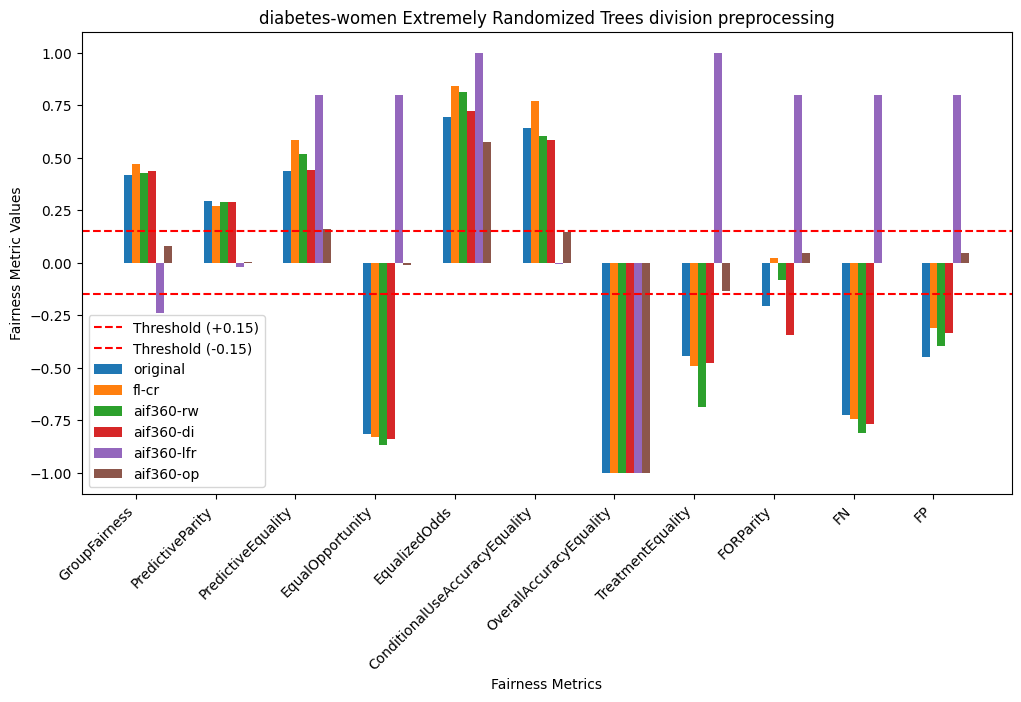

[[0.47558238115604984, 0.32064196380786775, 0.4685317460317461, -0.615262588288904, 0.5600438357938359, 0.4534831190294577, -1.0, 0.17232142857142857, 0.23015873015873015, -0.4114594247205665, -0.467799898732553], [0.47873060805214057, 0.311978378190917, 0.3905438311688312, -0.5585212652844231, 0.5794927294927296, 0.655216106557322, -1.0, 0.24154761904761904, 0.5208333333333333, -0.338942349937681, -0.41251703267885365], [0.4390062251918259, 0.3481294503856423, 0.33564814814814814, -0.6775490674738796, 0.6892822966507177, 0.47695836404737335, -1.0, -0.11452380952380954, 0.25656084656084654, -0.5365839088598001, -0.5407971132635347], [0.4517891088107605, 0.3142920281830886, 0.4512830687830688, -0.6210164616085667, 0.5739500119763278, 0.5226360044682412, -1.0, 0.14924242424242426, 0.22025252525252528, -0.44432975196217983, -0.49286758255264196], [-0.2181254672190666, -0.04484848484848484, 1.0, 0.8, 1.0, -0.03484848484848484, -1.0, 1.0, 0.8, 0.8, 1.0], [0.1686105745631118, -0.042031175171

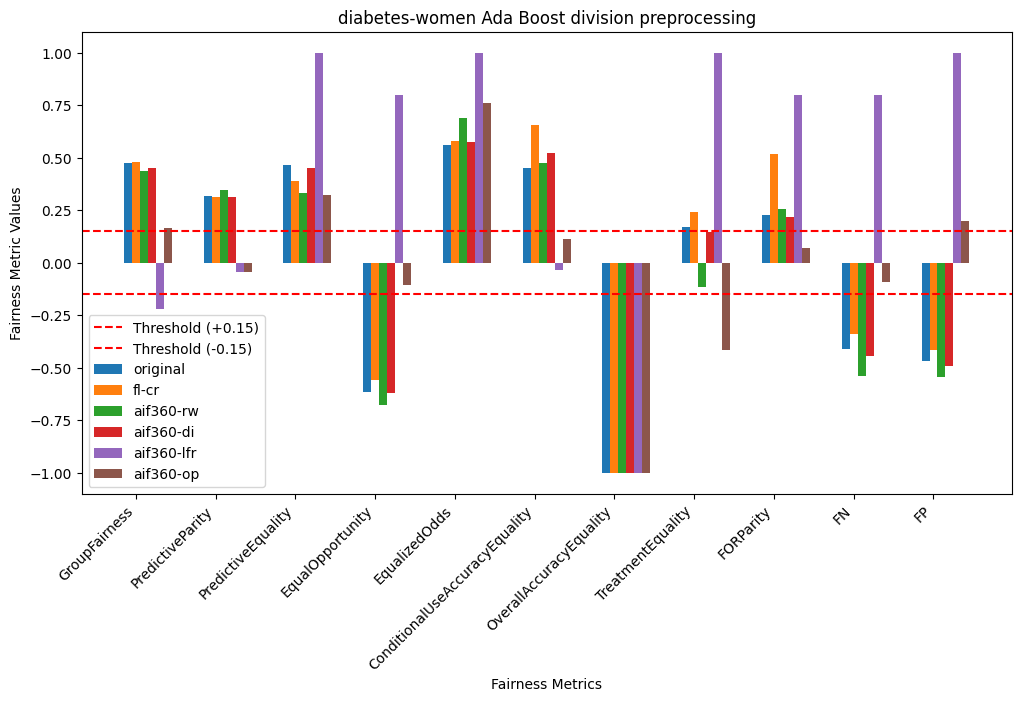

In [18]:
for m in models:
  grouped_bar(preprocessing_metrics["diabetes-women"], preprocessing_mitigation_list, "division", m, 'preprocessing')

serve che tutte le metriche siano comprese tra due estremi. inoltre sarebbe bello averle centrate sullo zero, per poter fare dei radar plot relativi a ciascuna configurazione e calcolare come valore finale l'area del radar (se è possibile).

altra cosa invece carina è di prendere tutte le metriche insieme e trasformarle in un vettore: con dimenzionality reduction si può mostrare tutti gli algoritmi su un unico grafico, però bisogna stare attenti a cosa mostriamo se facciamo riduzione dei vettori a due sole dimenzioni (es. cosa significa se ci troviamo nel quadrante in alto a destra o in quello in basso a sinistra?). però una cosa interessante è vedere come i diversi algoritmi sono in relazioni tra di loro, quindi una valutazione più qualitativa che quantitativa...

altra idea: se calcolassimo una componente su un asse o su una direzione? però chissà cosa scegliere...

In [19]:
# From a dictionary input, return a bidimensional np.array
# def vectorise(dictionary, dataset, comparison, model):
#   vector_l = []
#   for mitigation in mitigation_list:
#     l = []
#     for metric in metrics:
#       l.append(dictionary[dataset][mitigation][comparison][model][metric][0])
#     vector_l.append(l)

#   vector = np.asarray(vector_l)
#   return vector

PCA plot with vectors of metrics.

In [20]:
# pca = PCA(n_components=2)
# X_r = pca.fit_transform(vectorise(overall_metrics, 'diabetes-women', "division", "Logistic Regression"))

# fig = plt.figure()
# ax = fig.add_subplot(111)
# colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:cyan']
# ax.scatter(X_r[:, 0], X_r[:, 1], color=colors)
# for i, label in enumerate(models):
#     plt.annotate(label, (X_r[:, 0][i], X_r[:, 1][i]))
# plt.show()

Transform dictionary into a dataframe.

In [20]:
data_framing(overall_metrics, 'diabetes-women', "division", "Logistic Regression", preprocessing_mitigation_list)

<ipython-input-19-40070e9daa3a>:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, row_df], ignore_index=True)


,GroupFairness,PredictiveParity,PredictiveEquality,EqualOpportunity,EqualizedOdds,ConditionalUseAccuracyEquality,OverallAccuracyEquality,TreatmentEquality,FORParity,FN,FP
Mitigation,,,,,,,,,,,
original,0.460589,0.251476,0.488333,-0.898118,0.760294,0.576010,-1.0,-0.832500,-0.512500,-0.850422,-0.396571
fl-cr,0.448564,0.254333,0.438333,-0.898118,0.710294,0.573153,-1.0,-0.832500,-0.512500,-0.850422,-0.425792
aif360-rw,0.210723,0.312665,-0.158586,-0.165776,0.516414,0.324673,-1.0,0.100000,0.293333,0.065439,-0.682742
aif360-di,0.438993,0.257432,0.420556,-0.882967,0.692516,0.562849,-1.0,-0.782500,-0.512500,-0.825731,-0.432376
aif360-lfr,-0.223830,-0.016154,0.800000,0.200000,1.000000,0.009412,-1.0,0.800000,0.200000,0.200000,0.800000
aif360-op,-0.100507,0.083915,-0.205774,0.303390,0.089878,0.274349,-1.0,0.253636,0.073499,0.289339,-0.253287


In [23]:
# for m in models:
#   df_model = data_framing(preprocessing_metrics, 'diabetes-women', "division", m)
#   print(m)
#   print(df_model.head(6))

### Diabetes-women, all pre-processing techniques, subtraction, all ML models

Logistic Regression
[[0.2945878421374335, 0.1702405123057297, -0.24550028918449968, -0.17523397178717542, -0.24550028918449968, -0.07393517891599735, 0.17258340917157594, -0.5395238095238095, -0.13866881484528545, -0.09696244810993893, -0.07562096106163703], [0.2881905357401271, 0.17338986295508035, -0.22050028918449968, -0.17166254321574687, -0.22050028918449968, -0.07279881527963371, 0.17527701186517863, -0.5311904761904762, -0.1356385118149824, -0.09511059625808707, -0.08016641560709156], [0.14894690182242004, 0.2114731418154908, 0.08081357239251977, -0.0526098204173147, 0.09073420731315468, 0.1288059163059163, 0.15477001958680603, 0.06721500721500724, 0.15557359307359306, -0.015235283160047245, -0.1395347364267588], [0.28263498018457156, 0.1747708153360327, -0.2155002891844997, -0.166283755336959, -0.2155002891844997, -0.06325835573917415, 0.17472145630962305, -0.5123015873015874, -0.1283247729222961, -0.09205504070253152, -0.08266641560709156], [-0.1228674705488975, -0.01629629629

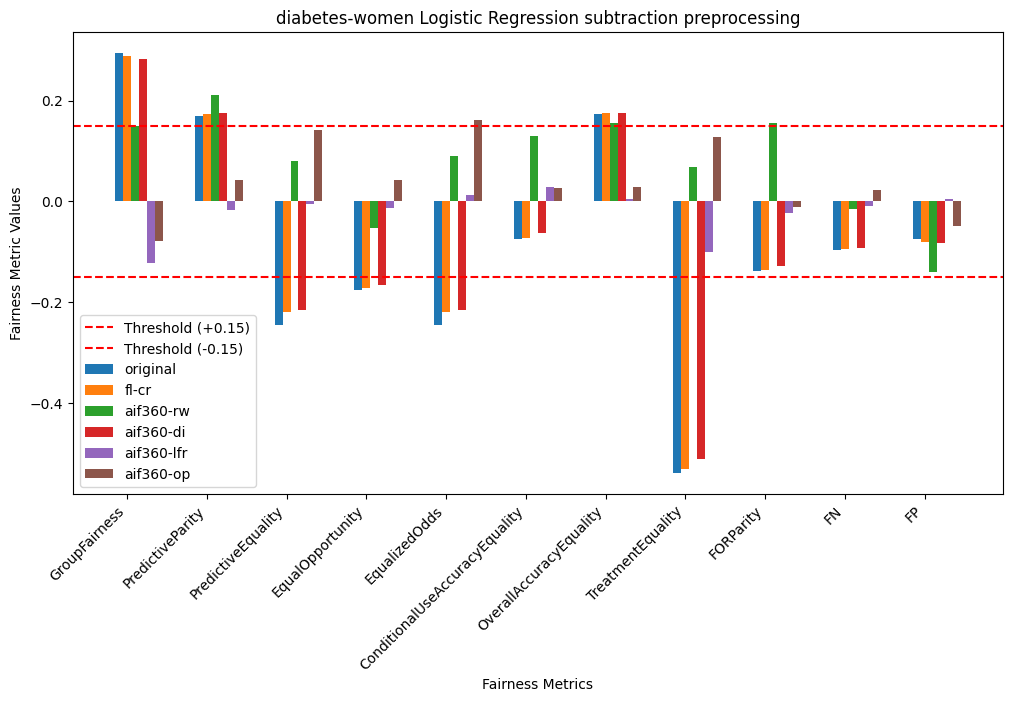

Decision Tree
[[0.19456274624401523, 0.20947941274411858, -0.1604154617312512, -0.12509641816993075, -0.165459321380374, 0.12858817481108503, 0.13143324177054977, 0.3711904761904762, 0.20970475431001745, -0.026374816462716732, -0.10505842530783305], [0.2774823966933277, 0.17714802842720462, -0.3479219683824947, -0.18228125691369398, -0.3748503689293163, 0.28773732750849457, 0.13316199217465646, 0.16765873015873015, 0.32531308508425216, -0.06869901688942634, -0.06446297528523019], [0.24702679982861214, 0.19119016655639792, -0.10919293425872371, -0.15678460396709823, -0.14896423751686907, 0.08625538204485571, 0.1517646914496324, -0.3065656565656566, 0.11583898471669367, -0.06277256809455649, -0.08899212335507593], [0.2837037253176156, 0.17492895117468085, -0.23525303643724702, -0.1909484741993323, -0.21561017929438986, 0.2365305231404303, 0.13258838541286128, -0.29101010101010105, 0.29069718980709697, -0.07152287782067268, -0.06106550759218861], [-0.14322695365838062, -0.0152384209992905

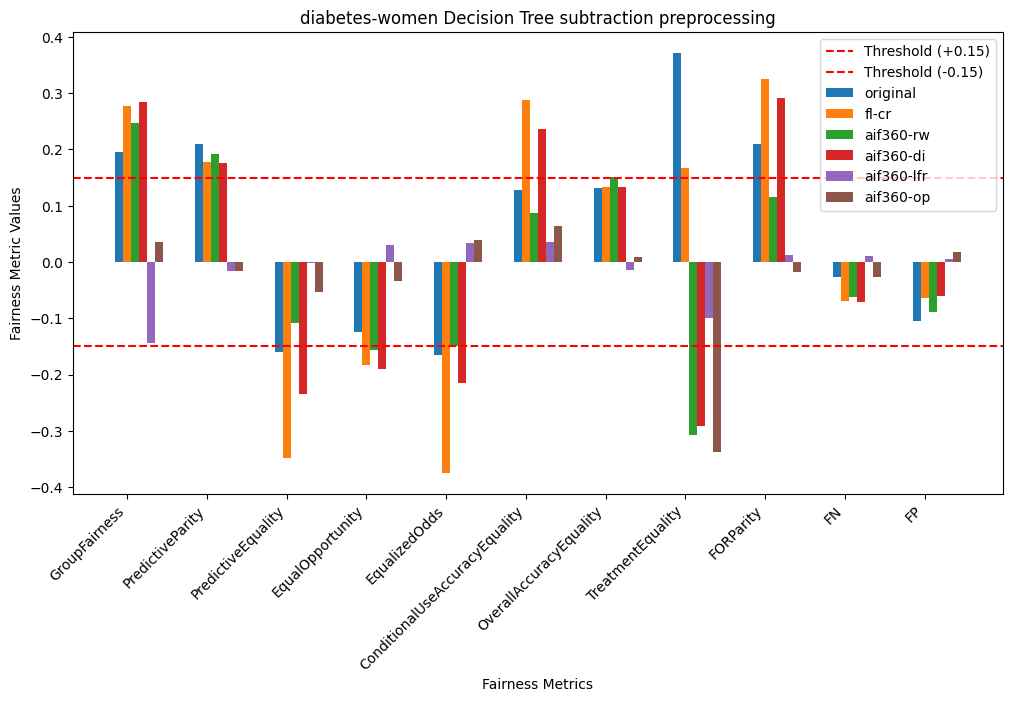

Bagging
[[0.18922126194620964, 0.20309524365589074, -0.10606588586851744, -0.08712183332177612, -0.10606588586851744, 0.14038461538461539, 0.17389518507731286, -0.15471330956625073, 0.09851981351981352, -0.044935045967195456, -0.12896013911011742], [0.11560287152704336, 0.24053091091761342, 0.14048390206284944, -0.050580527405470185, 0.13379559037453773, 0.056656850901036934, 0.19474308665075438, 0.11555555555555555, 0.07124458874458875, -0.018549801544333076, -0.1761932851064213], [0.15249545959678423, 0.22041639146172737, 0.09125554270291114, -0.06744952177875518, 0.12611485006221848, 0.04024840400366346, 0.18045504226079306, -0.00018016297428060656, 0.050897435897435894, -0.029852073384222872, -0.15060296887657018], [0.15816566414856775, 0.20836821767940733, 0.01883796028532872, -0.058287056986999784, 0.03516912911649754, 0.11290201668250448, 0.16692916522971407, -0.04928030303030304, 0.12884948384948386, -0.025924237144575125, -0.14100492808513893], [-0.12151350969493664, -0.058321

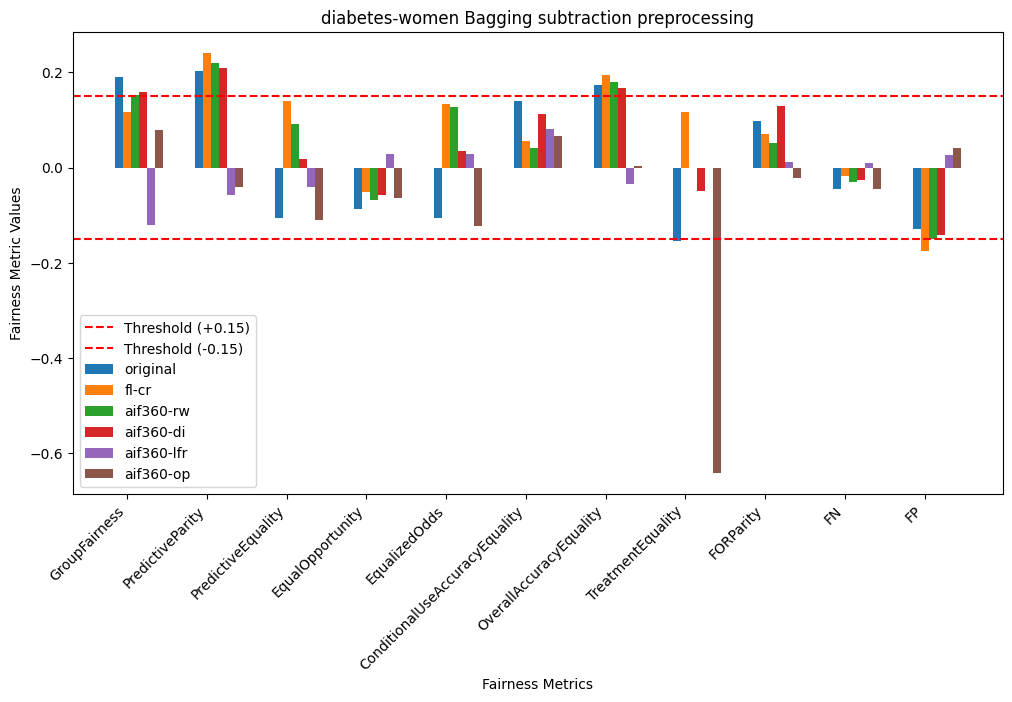

Random Forest
[[0.25985840921434356, 0.18252768784006962, -0.16437849431270488, -0.1500146983070324, -0.16558178663441825, -0.009000894616219701, 0.17311596549456343, -0.3242857142857143, -0.023665681583638236, -0.07986400980988773, -0.09325195568467572], [0.2517025946236867, 0.18817530487103565, -0.18879699248120305, -0.15054312535290798, -0.18879699248120305, -0.030180641759127796, 0.17218575690858234, -0.12008325008325009, -0.006333103395460379, -0.07532099822156876, -0.09686475868701358], [0.24366549414992775, 0.1770824638304625, -0.1864827935222672, -0.12933131164538486, -0.1817156673735621, 0.03616597893637743, 0.15238049248489688, -0.03164335664335664, 0.03386081067195618, -0.06139981577284652, -0.09098067671205035], [0.25293521737742336, 0.17811452413092485, -0.19622373240794294, -0.13567126396359805, -0.2003903990746096, 0.1078534455740338, 0.1634015446454839, -0.291984126984127, 0.1106312233518116, -0.07154520346688782, -0.09185634117859609], [-0.12773214768776817, -0.0337012

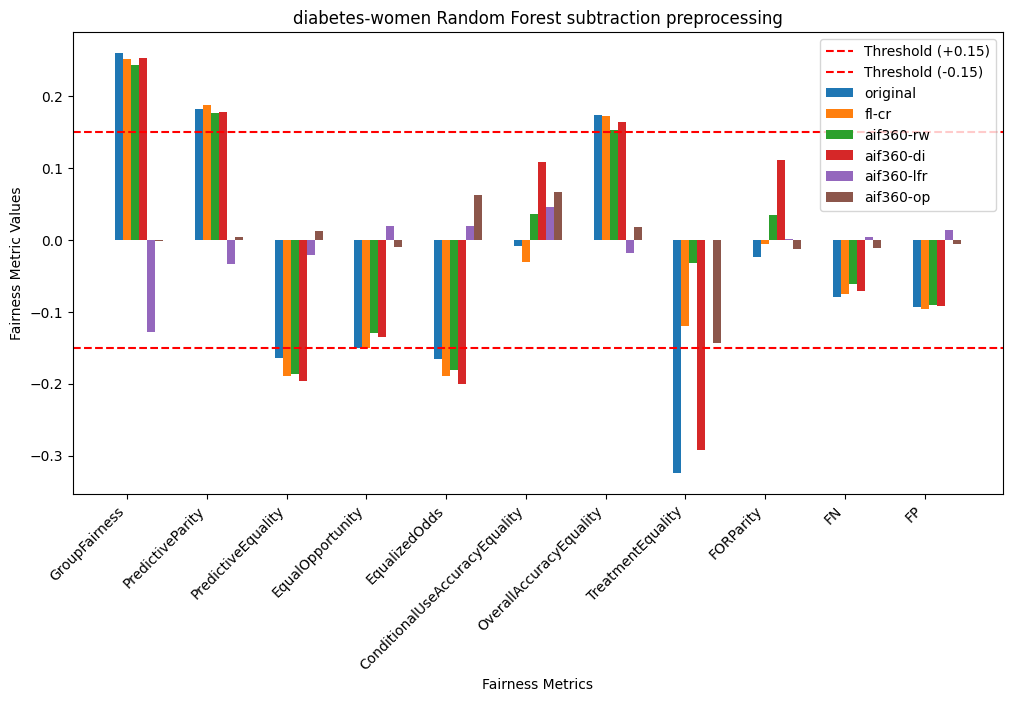

Extremely Randomized Trees
[[0.269801004555022, 0.19145143592700128, -0.20423848081742815, -0.17384928477319783, -0.23780324747716047, -0.05866336448433638, 0.18575461268674046, -0.2521212121212121, -0.0026590987272101683, -0.09115463107631544, -0.09459998161042502], [0.29862061448997324, 0.17370677253393346, -0.3231786196259881, -0.1848115863604994, -0.3578398775137906, 0.08333877233877232, 0.1683259442822656, -0.3487237762237762, 0.08922799422799424, -0.09685010184155365, -0.07147584244071195], [0.2780330164721427, 0.1894391828176799, -0.22173438403701562, -0.17952227406460816, -0.22173438403701562, 0.046372826436743356, 0.18406621340438017, -0.40685064935064935, 0.05542600373482724, -0.09442643739369563, -0.08963977601068453], [0.2765581720214918, 0.18610350762023087, -0.2267387218045113, -0.17410819538965994, -0.27199780577927035, -0.06461384963920459, 0.18239919248248304, -0.3186752136752137, -0.016976422270539915, -0.09285550470742163, -0.08954368777506141], [-0.13521411016973067

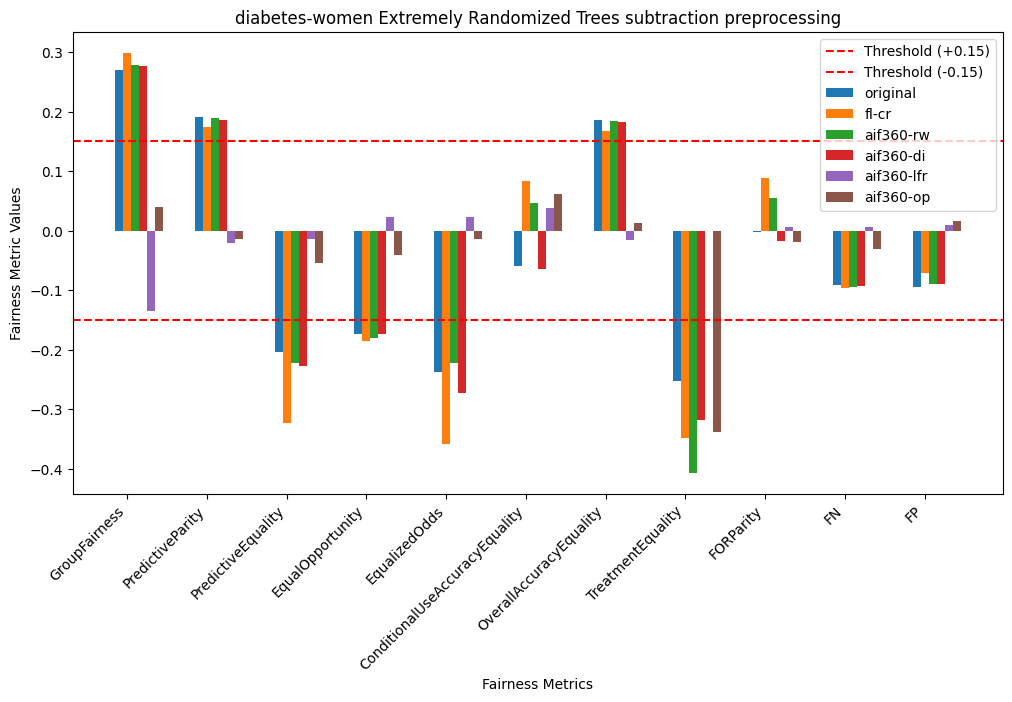

Ada Boost
[[0.27090493681748073, 0.20989619255400838, -0.22555041449778296, -0.20229392857968373, -0.2789234303707988, 0.08051876486087013, 0.18354185189566402, 0.05626984126984128, 0.09233677141571876, -0.09060021681200661, -0.09294163508365742], [0.26069383745034236, 0.20385070167564442, -0.2336227588201273, -0.19012911891058346, -0.2840225354355789, 0.24329941386442933, 0.16606031839762642, 0.1558080808080808, 0.24329941386442933, -0.07675390037941861, -0.08930641801820781], [0.2598061598258226, 0.22108541220972233, -0.12960502217081166, -0.20308976286236016, -0.1754385288624419, 0.03019959466506782, 0.1974961539632444, -0.05249999999999998, 0.09610294117647059, -0.09202797934996775, -0.10546817461327666], [0.2640817467363347, 0.20558782232637687, -0.235978648544438, -0.18771408511397067, -0.30548015676162127, 0.08413439949016974, 0.17708542468128088, 0.12222222222222223, 0.08943774405848708, -0.08396040816424201, -0.09312501651703886], [-0.12418717414279463, -0.04484848484848484, -

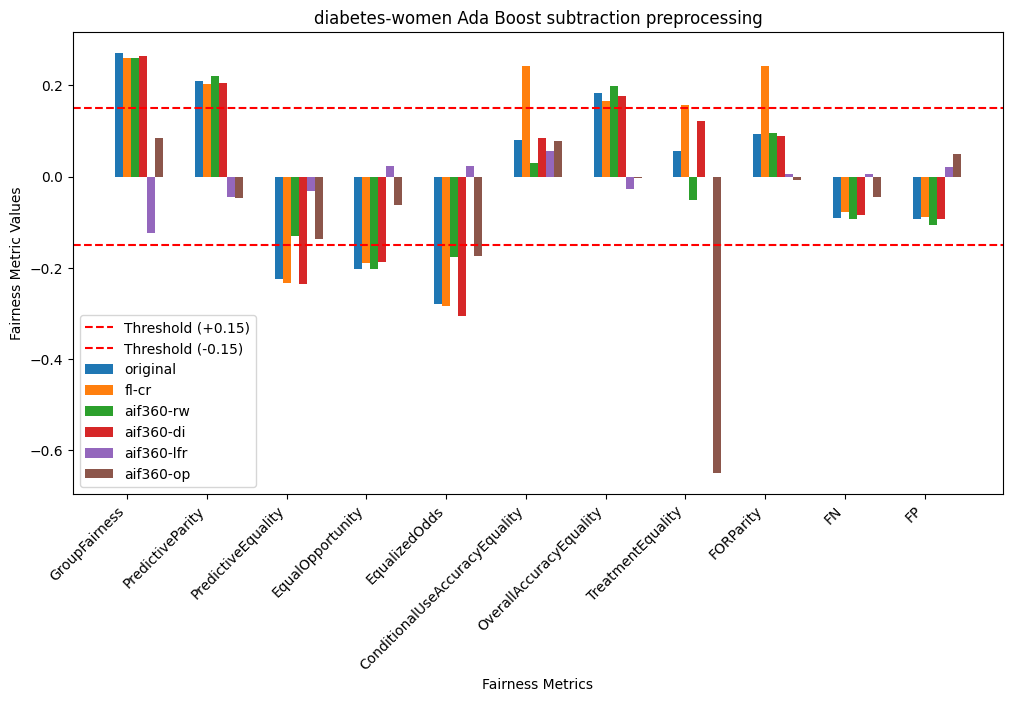

In [24]:
for m in models:
  print(m)
  grouped_bar(preprocessing_metrics["diabetes-women"], preprocessing_mitigation_list, "subtraction", m, 'preprocessing')

# In-processing results

In [25]:
for m in models:
  inprocessing_mitigation_list.insert(0, 'orig-'+str(m))

## Performance

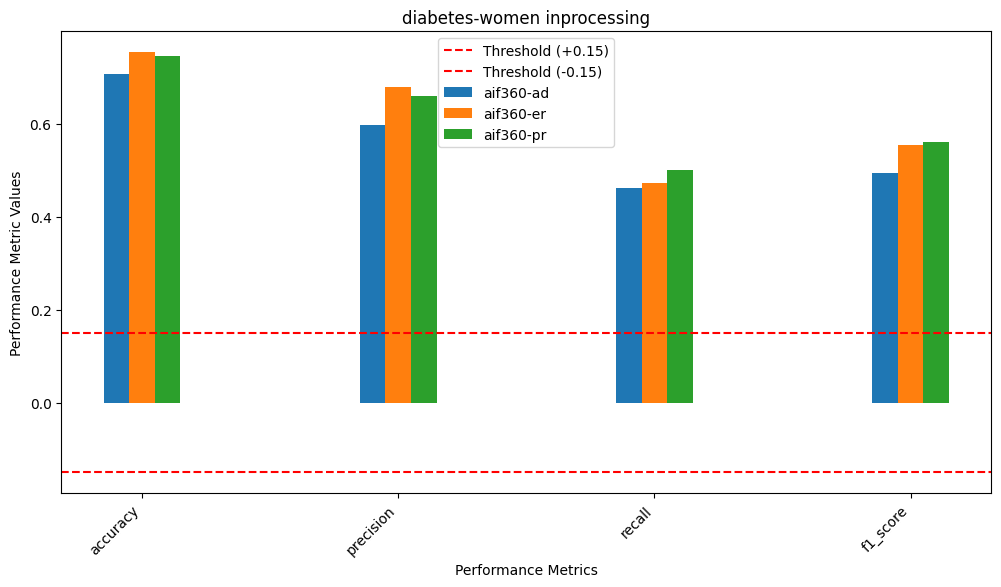

In [26]:
perf_grouped_bar_no_model(performance_metrics["diabetes-women"], ["aif360-ad", "aif360-er",'aif360-pr'], 'inprocessing')

In [45]:
perf_data_framing(performance_metrics, 'diabetes-women', None, ["aif360-ad", "aif360-er",'aif360-pr'])

,accuracy,precision,recall,f1_score
Mitigation,,,,
aif360-ad,0.707+/-0.040,0.598+/-0.155,0.462+/-0.129,0.495+/-0.092
aif360-er,0.754+/-0.052,0.679+/-0.109,0.473+/-0.058,0.555+/-0.071
aif360-pr,0.746+/-0.047,0.659+/-0.127,0.501+/-0.058,0.562+/-0.054


### Diabetes-women, two over three in-processing techniques, division, no ML models

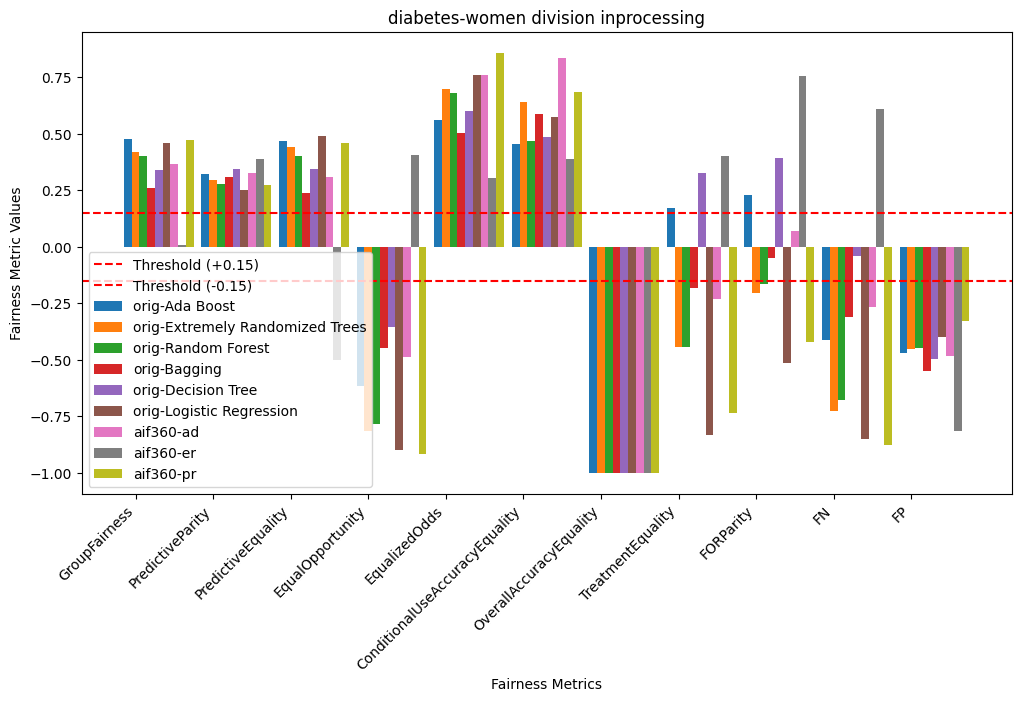

In [27]:
grouped_bar_no_model(inprocessing_metrics["diabetes-women"], inprocessing_mitigation_list, "division", 'inprocessing')

### Diabetes-women, two over three in-processing techniques, subtraction, no ML models

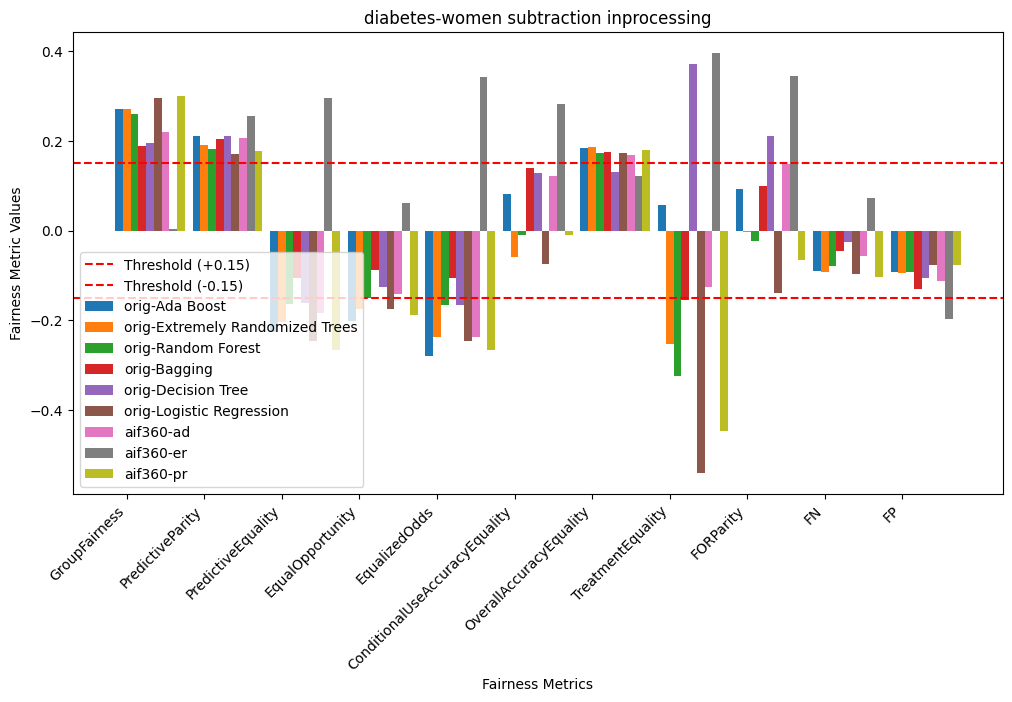

In [28]:
grouped_bar_no_model(inprocessing_metrics["diabetes-women"], inprocessing_mitigation_list, "subtraction", 'inprocessing')

# Post-processing results

In [19]:
postprocessing_mitigation_list.insert(0,'original')

## Performance

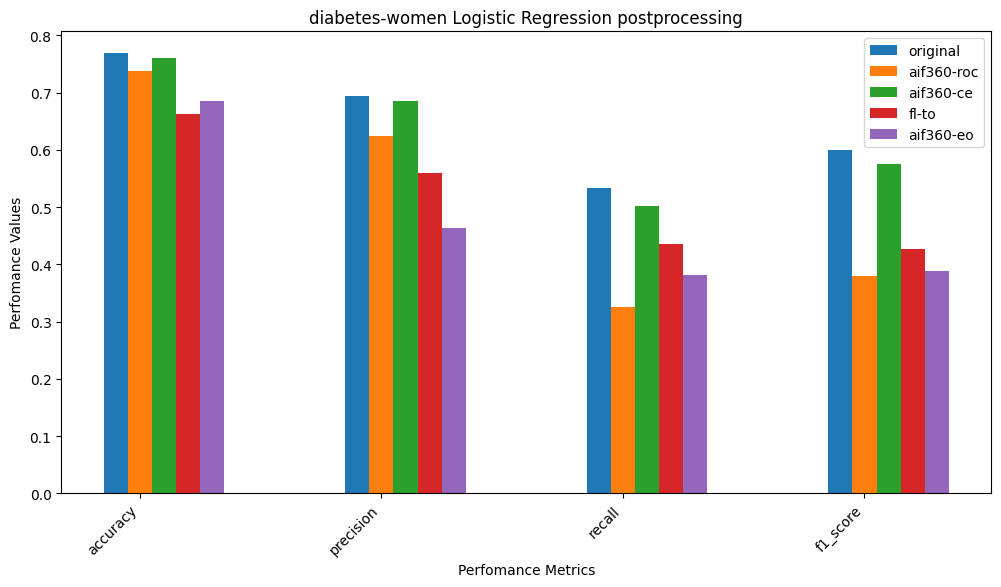

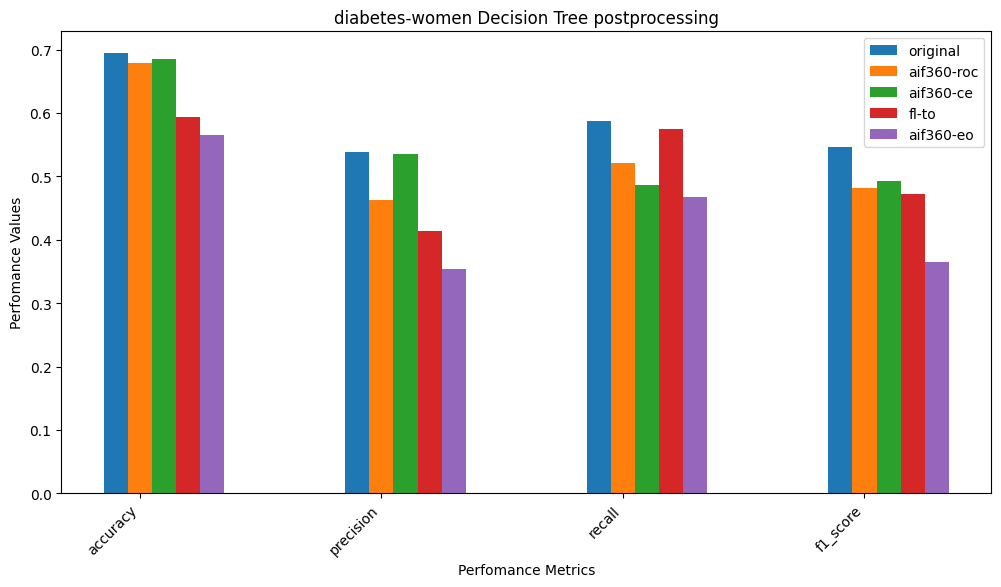

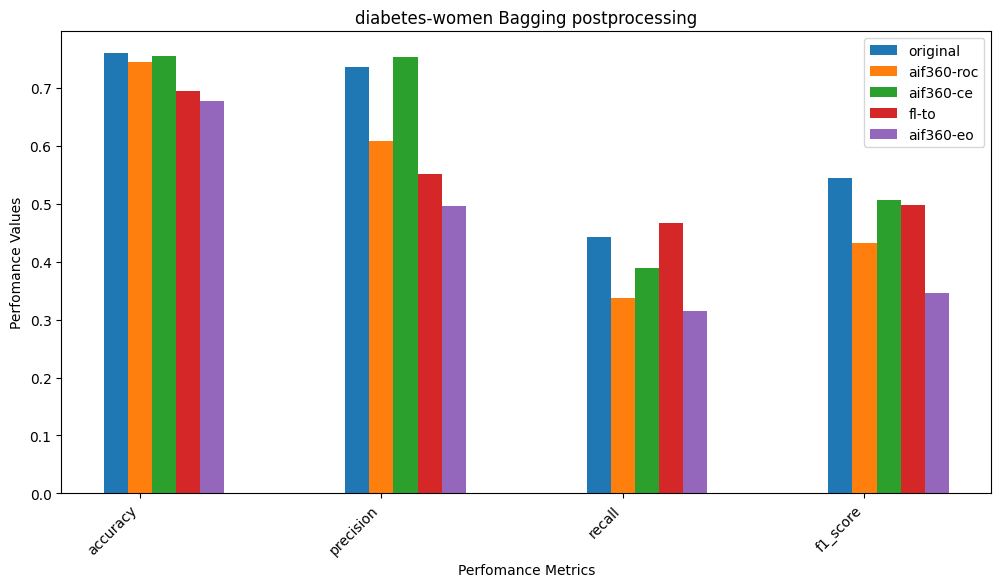

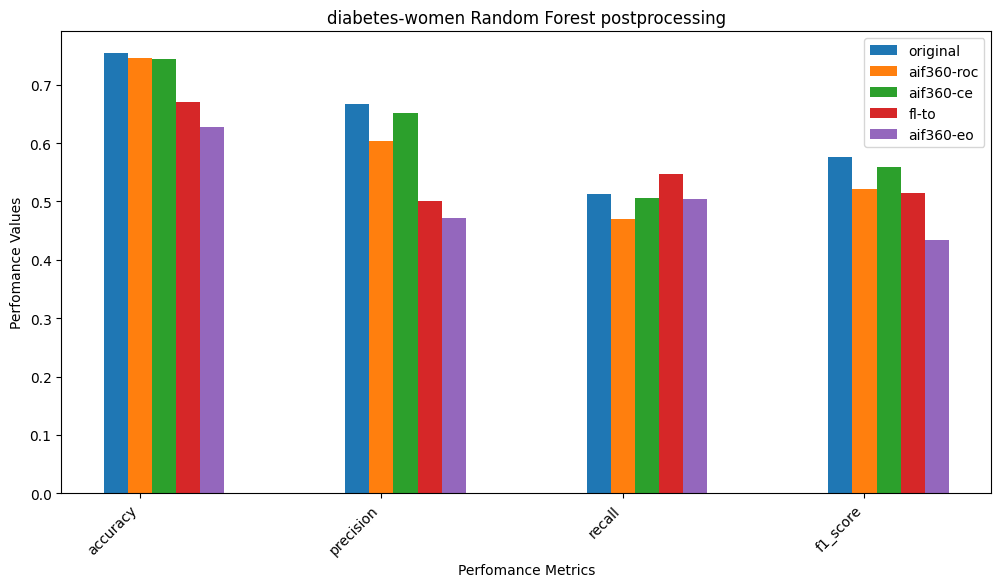

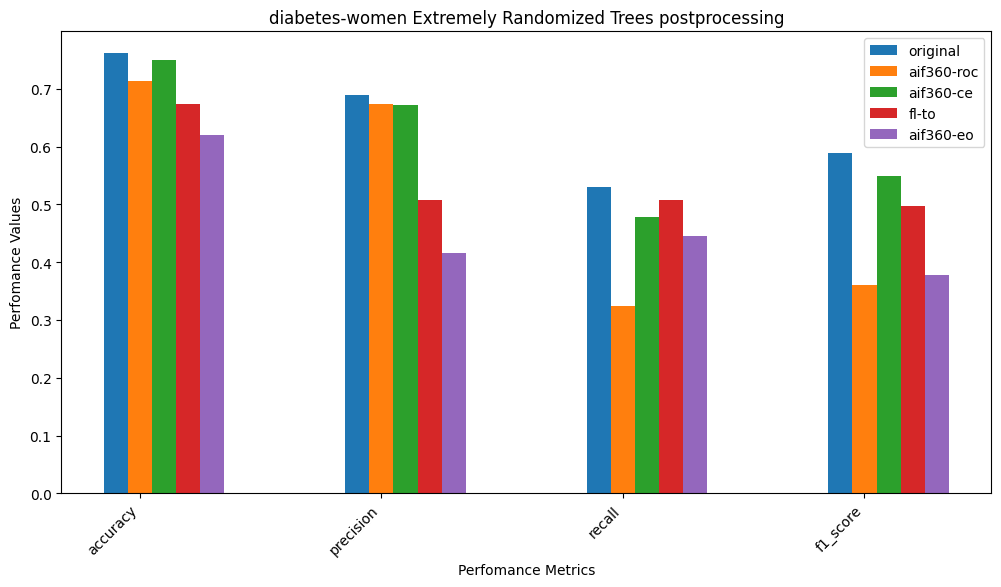

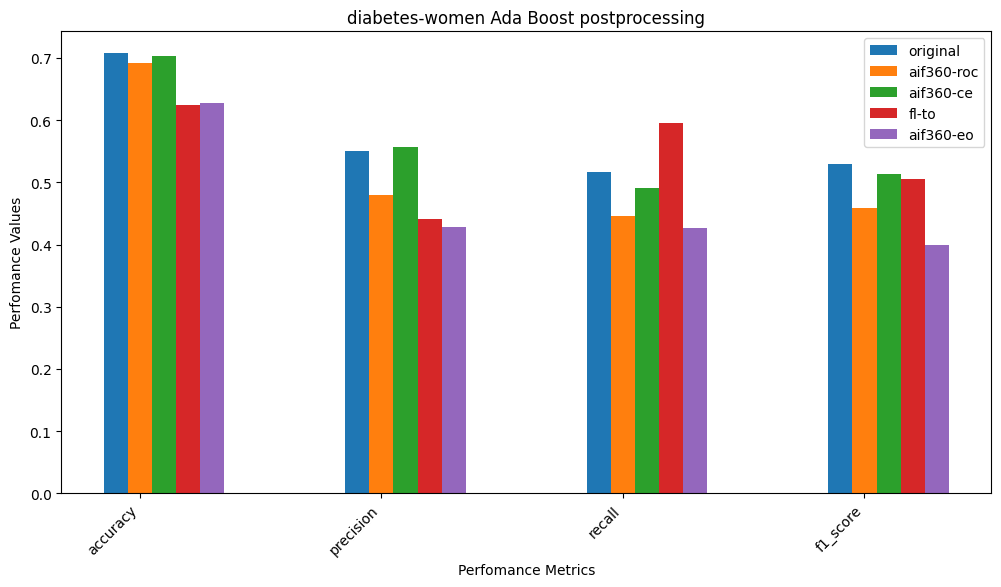

In [20]:
for m in models:
  perf_grouped_bar(performance_metrics["diabetes-women"], postprocessing_mitigation_list, m, 'postprocessing')

In [21]:
perf_data_framing(performance_metrics, 'diabetes-women', "Logistic Regression", postprocessing_mitigation_list)

,accuracy,precision,recall,f1_score
Mitigation,,,,
original,0.769+/-0.046,0.693+/-0.083,0.533+/-0.037,0.600+/-0.045
aif360-roc,0.737+/-0.062,0.624+/-0.334,0.325+/-0.248,0.380+/-0.274
aif360-ce,0.760+/-0.046,0.685+/-0.089,0.501+/-0.046,0.575+/-0.048
fl-to,0.663+/-0.046,0.559+/-0.198,0.435+/-0.188,0.427+/-0.119
aif360-eo,0.685+/-0.090,0.464+/-0.252,0.381+/-0.265,0.389+/-0.211


### Diabetes-women, post-processing techniques, division, ML models

Logistic Regression
[[0.4605894995402635, 0.251475751585726, 0.4883333333333333, -0.8981180223285486, 0.7602941176470589, 0.5760102707749767, -1.0, -0.8324999999999999, -0.5125, -0.8504223521767381, -0.396570901412686], [0.24758119064485787, 0.3738042841642585, 0.07444444444444445, -0.09811802232854865, 0.34640522875817, 0.7045816993464052, -1.0, -0.032499999999999994, 0.2875, -0.05042235217673814, -0.5412933144834862], [0.515526851316325, 0.20901290116594134, 0.9441666666666666, -0.9284210526315789, 0.9441666666666666, 0.8494444444444443, -1.0, -0.9075, -0.7125, -0.8998050682261208, -0.23345788240593937], [-0.037214643188155615, 0.33257845722687895, -0.11206349206349206, 0.5831831472620947, 0.2787698412698413, 0.3719507990663261, -1.0, 0.55, 0.975, 0.8245885167464115, -0.6619434144854914], [0.13981781962642675, 0.42473944914734396, -0.1962962962962963, 0.035354864433811806, 0.2121303258145363, 0.49652985318774795, -1.0, 0.45, 0.7746428571428572, 0.37033744811121727, -0.697161209121424

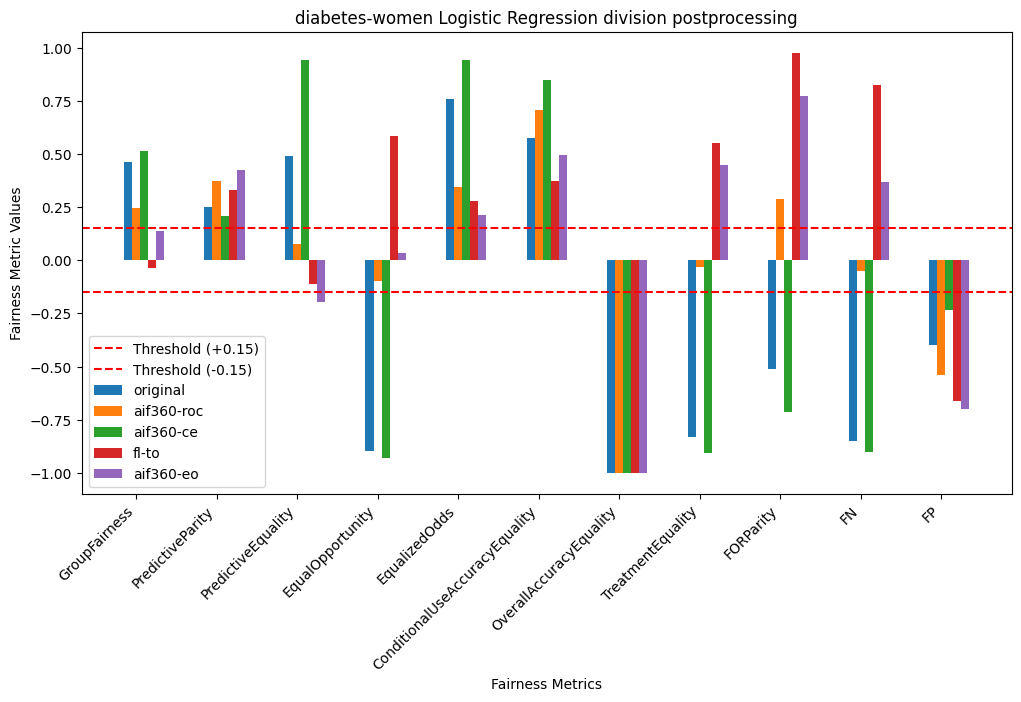

Decision Tree
[[0.33989108464399215, 0.3438969373022759, 0.343015873015873, -0.35415698336750967, 0.5994817927170868, 0.48677124086985674, -1.0, 0.3244318181818182, 0.39455266955266954, -0.041251729437637774, -0.49518686455132405], [0.3087113838534866, 0.33571367651955886, 0.29444444444444445, -0.07901830875891025, 0.5871682995367206, 0.45564290170613697, -1.0, 0.4585714285714285, 0.6345833333333333, 0.17315232988521045, -0.4299319287538782], [0.5461289008926933, 0.3017867314472353, 0.7206679894179894, -0.6535571884256095, 0.8118678669815033, 0.8935659112129699, -1.0, -0.29523809523809524, -0.06904761904761902, -0.4916559777670888, -0.22870507133353768], [-0.07530028337303142, 0.35437653989027823, 0.06940476190476189, 0.4446693267745899, 0.21487044817927167, 0.5384780578898226, -1.0, 0.75, 0.7221328671328671, 0.8006846153846154, -0.5871164546011745], [0.07596316919444435, 0.43834868143061423, -0.1820687134502924, 0.10494742266922716, 0.22932060543515656, 0.3328752527428998, -1.0, 0.559

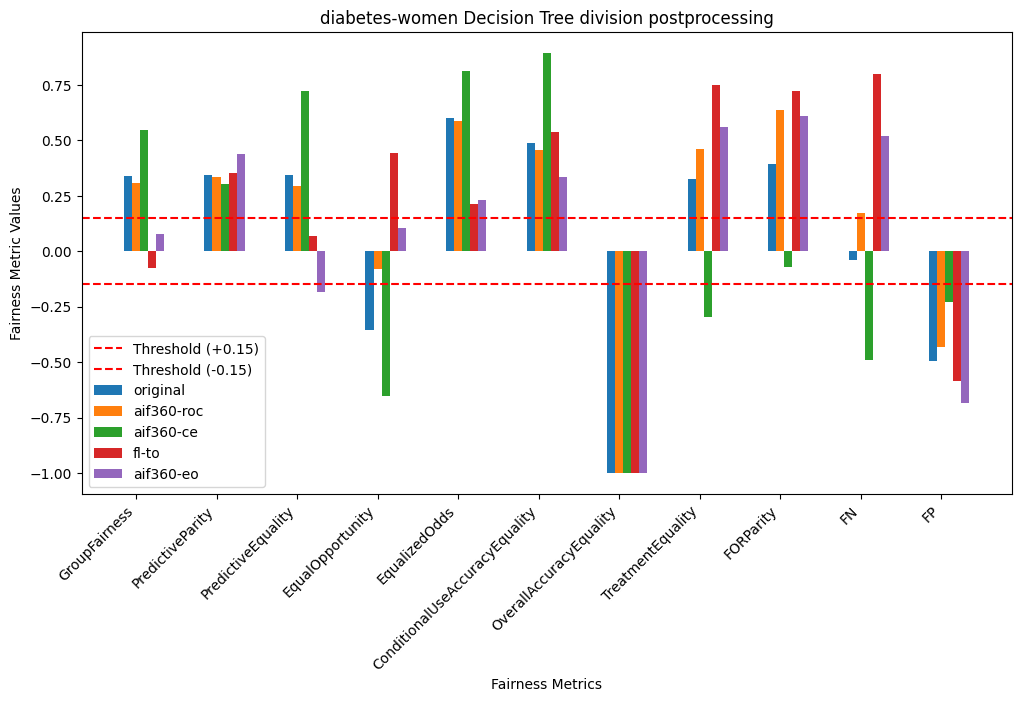

Bagging
[[0.2605478910819127, 0.31020670684164725, 0.2360479797979798, -0.4488972431077694, 0.5026994569757728, 0.587945678015401, -1.0, -0.18333333333333335, -0.05, -0.31015395894428155, -0.5489289327914115], [0.18695291538409814, 0.3619921645115364, 0.04706293706293705, -0.06738095238095239, 0.3105398110661269, 0.621477167431322, -1.0, 0.175, 0.2, 0.058064516129032254, -0.5961813477201707], [0.32932450120991213, 0.2450804123825236, 0.7869310754604872, -0.8400000000000001, 0.7869310754604872, 0.9291497975708503, -1.0, -0.8, -0.8, -0.8, -0.3592470946855419], [-0.09168977392099592, 0.302042545475922, -0.06924242424242424, 0.7171770334928229, 0.09381977671451354, 0.4845749634774476, -1.0, 0.8, 0.9285714285714285, 0.916148148148148, -0.6589646516614414], [0.08628104954845192, 0.40925761957340906, -0.20799865643615645, -0.04027113237639557, 0.20524037366142628, 0.48463561000403105, -1.0, 0.3375, 0.5641353383458647, 0.24543300218300218, -0.6934299259958429]]


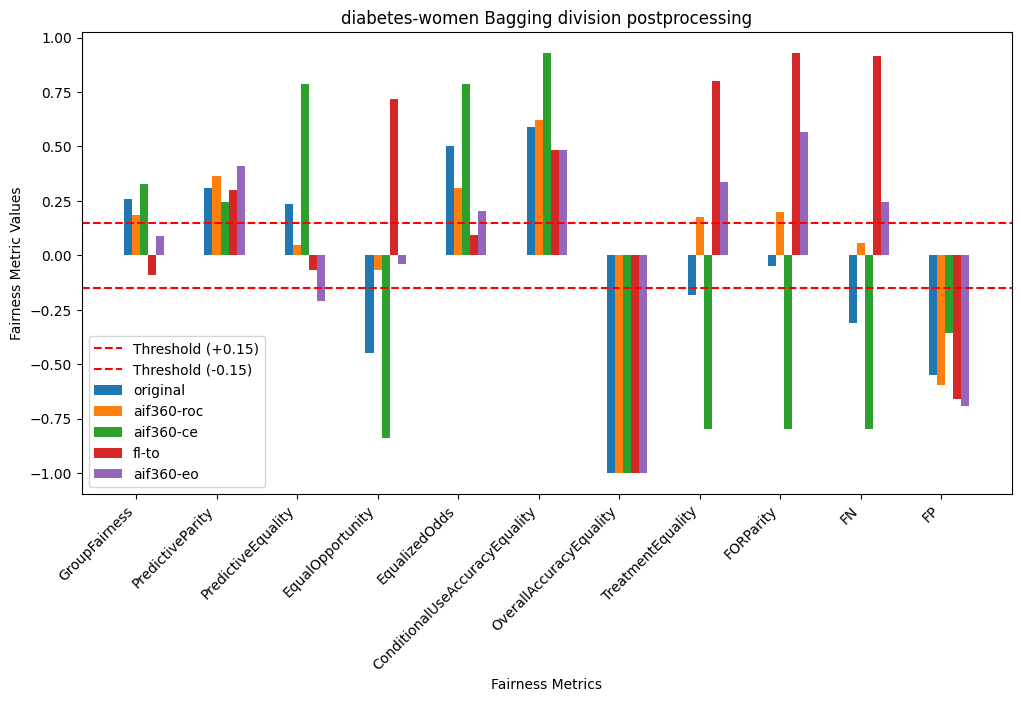

Random Forest
[[0.40169602657997655, 0.27580043819493943, 0.4004960317460318, -0.7846289967342599, 0.6809126984126984, 0.4697357503607503, -1.0, -0.44361111111111107, -0.16354166666666664, -0.6790678488335534, -0.4484646877865893], [0.35316813627949983, 0.32156308140491746, 0.19174603174603175, -0.4381962481962482, 0.5066721840251251, 0.6779803675856307, -1.0, 0.05833333333333333, 0.09166666666666665, -0.3026605300314978, -0.5175003856170239], [0.6082279997998938, 0.2042224880072802, 0.9727272727272727, -0.9566666666666667, 0.9727272727272727, 0.95, -1.0, -0.9458333333333332, -0.6, -0.9368947368421052, -0.09703427947735001], [-0.04637765896795411, 0.30369352242946784, -0.04101010101010098, 0.6430170122275386, 0.32732323232323235, 0.4418833282663324, -1.0, 0.575, 0.8679487179487179, 0.8472578347578349, -0.6615269410447301], [0.13503497996389413, 0.3179128727364774, 0.11170830327080324, -0.010190287631303996, 0.3251106301106301, 0.18562954259437636, -1.0, 0.5702380952380952, 0.7575721900

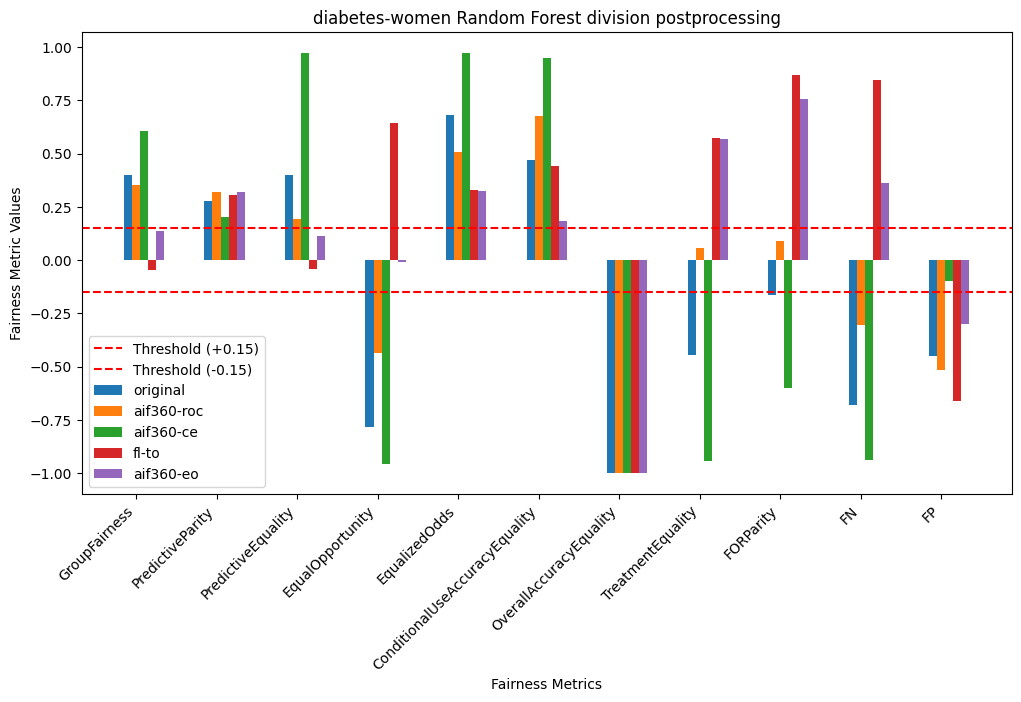

Extremely Randomized Trees
[[0.41883099962087844, 0.29486808106975476, 0.43994859307359313, -0.8162481962481962, 0.6962121212121212, 0.6409898585534248, -1.0, -0.445, -0.20285714285714285, -0.7253449034773313, -0.4500222481777378], [0.2798559837634541, 0.3960948135794462, 0.1688888888888889, -0.04702380952380954, 0.41666666666666663, 0.8508488063660478, -1.0, 0.17250000000000001, 0.3375, 0.022548047538200368, -0.5237149753660789], [0.540754193202052, 0.2092976447909237, 0.9454545454545453, -0.9650000000000001, 0.9454545454545453, 1.0, -1.0, -0.975, -0.8, -0.9552083333333334, -0.13650690792803774], [-0.013324176557418178, 0.2964814015274726, 0.07869047619047621, 0.5361642743221691, 0.5465692640692642, 0.41601891633846516, -1.0, 0.5088888888888888, 0.8733333333333334, 0.7007835765057987, -0.6116851516213145], [0.12310301952167983, 0.44027851938301765, -0.36875, 0.0392277663856611, 0.2398076923076923, 0.4789588131036341, -1.0, 0.16666666666666666, 0.47726449275362315, 0.32617587451534824,

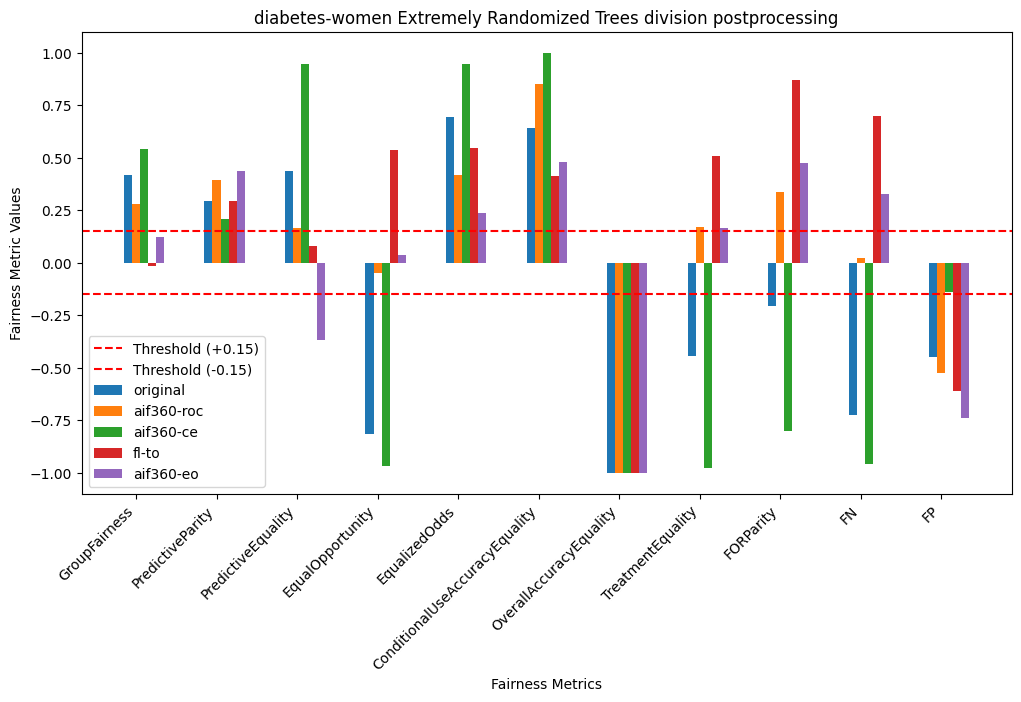

Ada Boost
[[0.47558238115604984, 0.32064196380786775, 0.4685317460317461, -0.615262588288904, 0.5600438357938359, 0.4534831190294577, -1.0, 0.17232142857142857, 0.23015873015873015, -0.4114594247205665, -0.467799898732553], [0.41456714802660616, 0.3256352246749676, 0.4478306878306878, -0.446807701070859, 0.54111790986791, 0.6185424585547414, -1.0, 0.2223412698412698, 0.47169312169312166, -0.26340786431703245, -0.41381637703108265], [0.6480810158304833, 0.25856620063063696, 0.775, -0.8076190476190476, 0.975, 0.7512941176470589, -1.0, -0.8, -0.4607142857142857, -0.7174565960355435, -0.20612511548900914], [-0.14243792481304962, 0.3310883623600342, -0.36277777777777775, 0.6008025746183641, 0.39616959064327484, 0.20400655527822714, -1.0, 0.12272727272727273, 0.803108003108003, 0.8923787878787879, -0.7259022570001631], [0.0704783786165735, 0.4250227127683822, -0.20392043686161337, 0.08407533986481351, 0.018635954115830265, 0.4470007347464042, -1.0, 0.7633333333333333, 0.6938381834215168, 0.4

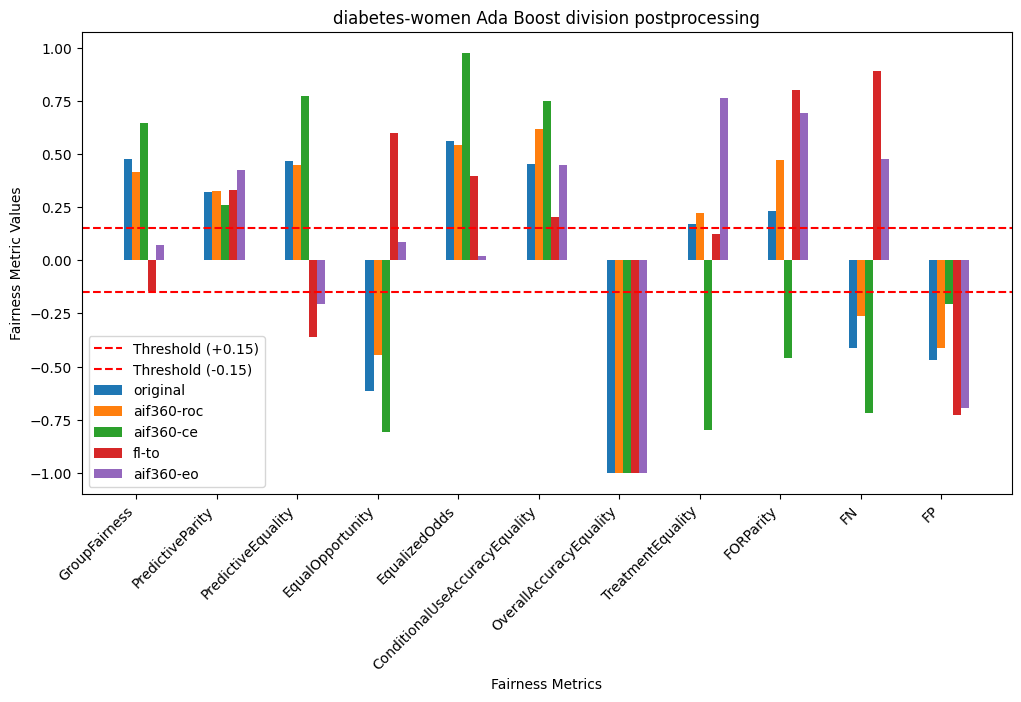

In [22]:
for m in models:
  print(m)
  grouped_bar(postprocessing_metrics["diabetes-women"], postprocessing_mitigation_list, "division", m, 'postprocessing')

### Diabetes-women, post-processing techniques, subtraction, no ML models

Logistic Regression
[[0.2945878421374335, 0.1702405123057297, -0.24550028918449968, -0.17523397178717542, -0.24550028918449968, -0.07393517891599735, 0.17258340917157594, -0.5395238095238095, -0.13866881484528545, -0.09696244810993893, -0.07562096106163703], [0.1549053024548938, 0.22960559167080907, -0.004547908232118747, -0.10080215360535727, -0.004547908232118747, -0.12070081850516634, 0.2214722980604648, -0.2633333333333333, -0.0043550893550893584, -0.05156562271311353, -0.16990667534735132], [0.3296254849008827, 0.1415180864276236, -0.5155002891844997, -0.17977942633263, -0.5155002891844997, -0.060290391417319886, 0.14495317381553413, -0.5645238095238094, -0.18866881484528547, -0.10066615181364262, -0.04428702200189151], [-0.029743930928210545, 0.20936035849824366, 0.047713996529786015, 0.11681091315244634, 0.16644776276355225, 0.411768648018648, 0.006714599068894883, 0.30214285714285716, 0.4403400765900766, 0.14813784347422362, -0.1548524425431185], [0.068256404679086, 0.261726582

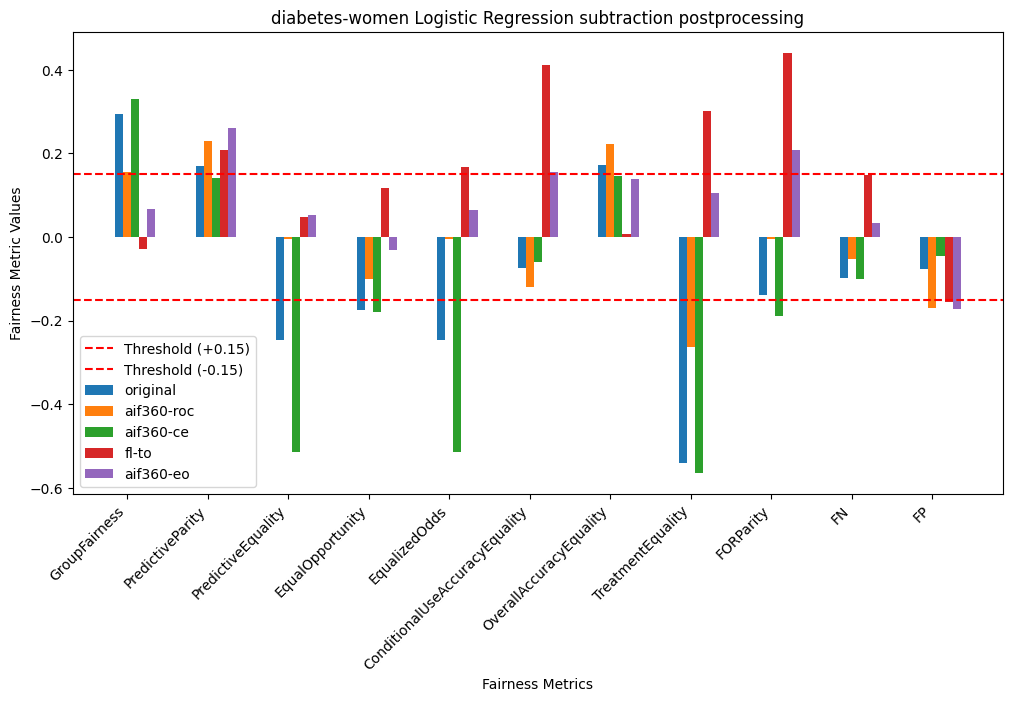

Decision Tree
[[0.19456274624401523, 0.20947941274411858, -0.1604154617312512, -0.12509641816993075, -0.165459321380374, 0.12858817481108503, 0.13143324177054977, 0.3711904761904762, 0.20970475431001745, -0.026374816462716732, -0.10505842530783305], [0.16964629799984365, 0.20224416042894303, -0.15894110275689222, -0.09505982099517568, -0.2209221918432444, 0.14463522052995736, 0.12354037932903372, 0.30722222222222223, 0.26443449532923213, -0.009970161119872895, -0.11357021820916083], [0.31298613488148375, 0.18205008803484307, -0.4416425679583574, -0.21669145690312738, -0.4690528674224327, 0.14291254041281723, 0.15999072011256638, -0.09650793650793651, 0.0063412829860198475, -0.09986524995245925, -0.06012547016010711], [-0.04791643347089117, 0.20259040821579521, -0.07362974744553694, 0.12643119244091783, 0.08446928802191958, 0.37609146828254375, -0.07739432152958231, 0.7666666666666667, 0.37609146828254375, 0.19927855504480252, -0.12188423351522022], [0.028336949582576775, 0.253851595238

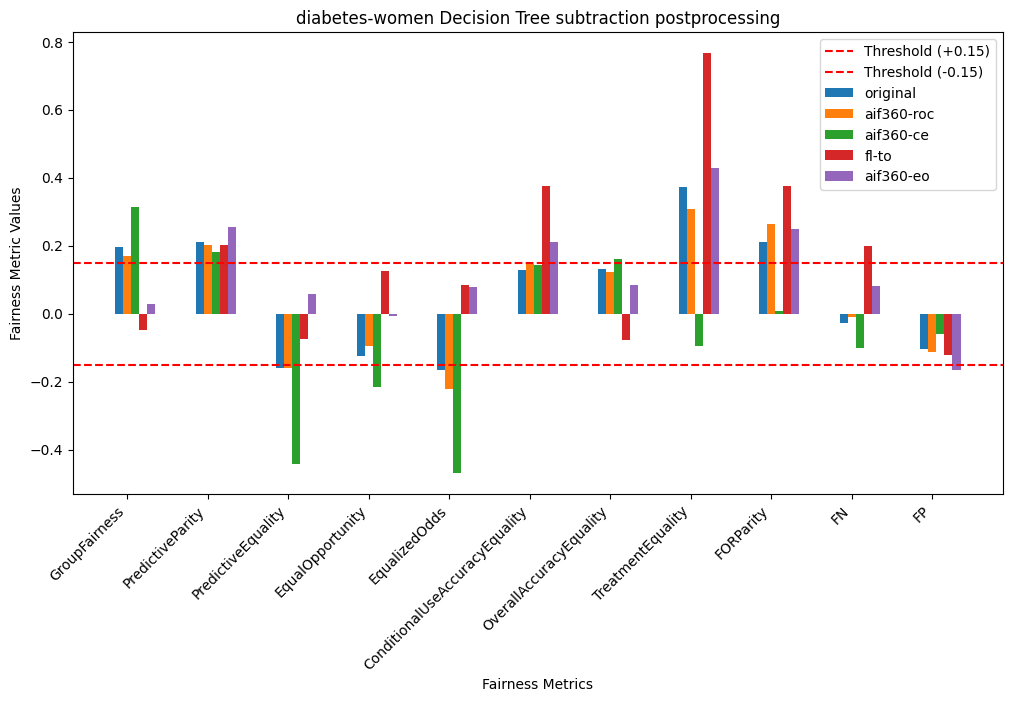

Bagging
[[0.18922126194620964, 0.20309524365589074, -0.10606588586851744, -0.08712183332177612, -0.10606588586851744, 0.14038461538461539, 0.17389518507731286, -0.15471330956625073, 0.09851981351981352, -0.044935045967195456, -0.12896013911011742], [0.13553078575573344, 0.22787870768041207, -0.0035658858685174433, -0.06218947401441681, 0.014098065677013055, 0.012047040678619636, 0.1941465078286356, -0.03324828766005237, 0.16522435897435897, -0.028215469247618735, -0.16593103858101685], [0.24437985305641363, 0.16172144487645373, -0.4385658858685174, -0.09599531808770939, -0.4385658858685174, -0.024857922286175903, 0.1399044165865444, -0.276763220439691, -0.1405061605061605, -0.055518957276913215, -0.08438545930963115], [-0.07036088594732531, 0.19862590401107233, 0.0529222093695778, 0.1892334488229797, 0.22240994385731225, 0.5320641858141857, -0.033275753953400336, 0.8155882352941177, 0.5320641858141857, 0.18844149749492858, -0.15516574354152826], [0.0535907624230955, 0.24835126672987454

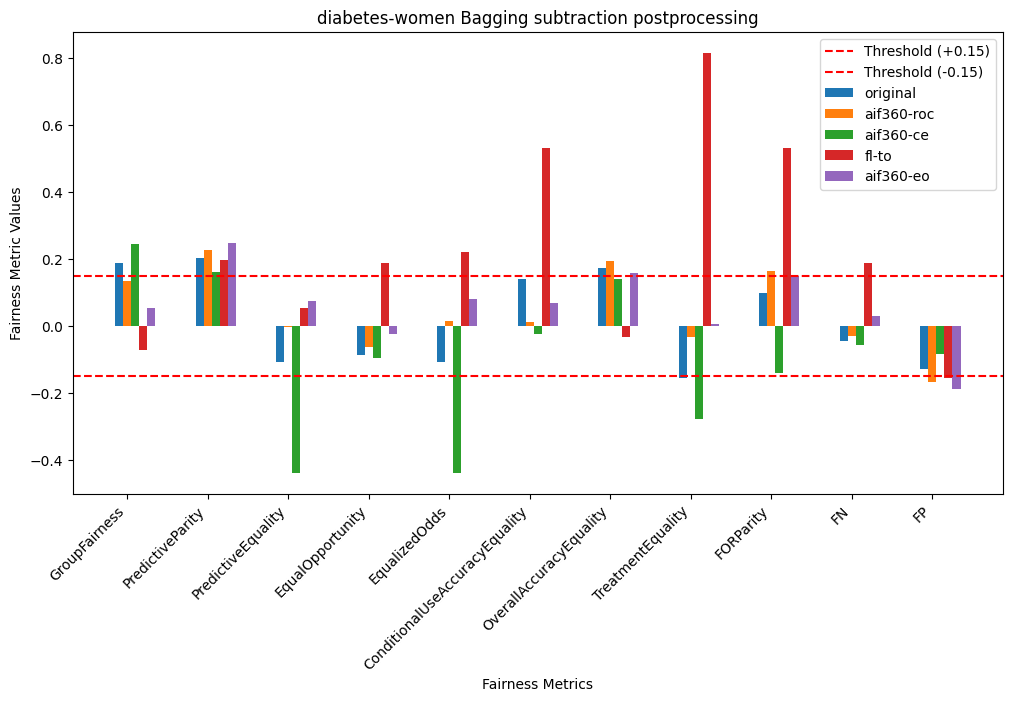

Random Forest
[[0.25985840921434356, 0.18252768784006962, -0.16437849431270488, -0.1500146983070324, -0.16558178663441825, -0.009000894616219701, 0.17311596549456343, -0.3242857142857143, -0.023665681583638236, -0.07986400980988773, -0.09325195568467572], [0.2235560867238326, 0.2064314995317104, -0.11583453826874882, -0.14061256979735243, -0.14660834779255832, -0.0567503895368921, 0.19684626655258786, -0.15883838383838383, 0.04728819330936035, -0.07357799909364444, -0.12326826745894341], [0.36704252070745336, 0.13342326839468166, -0.5731672932330827, -0.21795925089403348, -0.5731672932330827, -0.01736283848642567, 0.1518592584716188, -0.6630452880452881, -0.14521669932795253, -0.1228277120449703, -0.029031546426648493], [-0.03380001731165509, 0.1988443244681385, 0.005204839020628488, 0.14039976216892697, 0.1763714392332813, 0.44592407592407585, -0.04027858815009879, 0.64, 0.44592407592407585, 0.17366248027544273, -0.13338389212534393], [0.06266228109838684, 0.18851996038533433, 0.03216

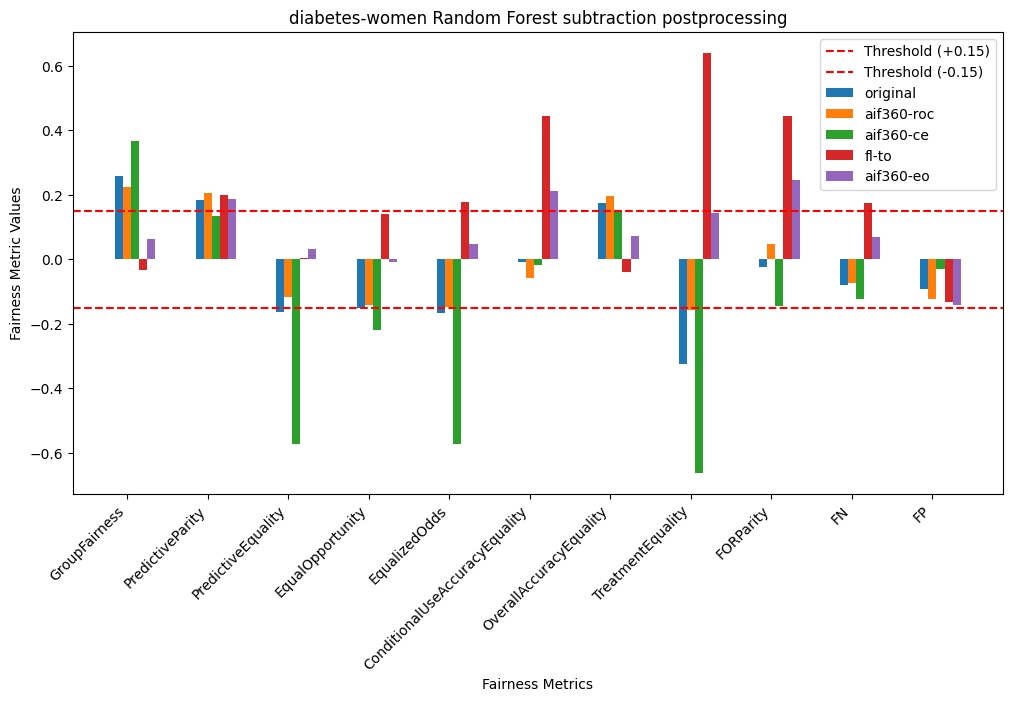

Extremely Randomized Trees
[[0.269801004555022, 0.19145143592700128, -0.20423848081742815, -0.17384928477319783, -0.23780324747716047, -0.05866336448433638, 0.18575461268674046, -0.2521212121212121, -0.0026590987272101683, -0.09115463107631544, -0.09459998161042502], [0.16318238759919573, 0.2324942826707817, -0.04271592442645074, -0.12025609354413702, -0.07574414715719062, -0.12790900341053751, 0.23917598588718345, -0.17714285714285713, 0.0286976911976912, -0.0645560091986238, -0.1746199766885596], [0.3467620278085394, 0.13682285897239074, -0.569655629458261, -0.19267257199322416, -0.569655629458261, -0.048517193623247155, 0.1470466504010548, -0.6159956709956709, -0.2234481417985254, -0.11028116156023134, -0.036765488840823465], [-0.015553376111012235, 0.19514199445087138, -0.061999951802583365, 0.13116697169471772, 0.05909943492180334, 0.4941708291708292, -0.0429585098539475, 0.4891558441558441, 0.4941708291708292, 0.16587912052704565, -0.12292061067309812], [0.04745457494814901, 0.26

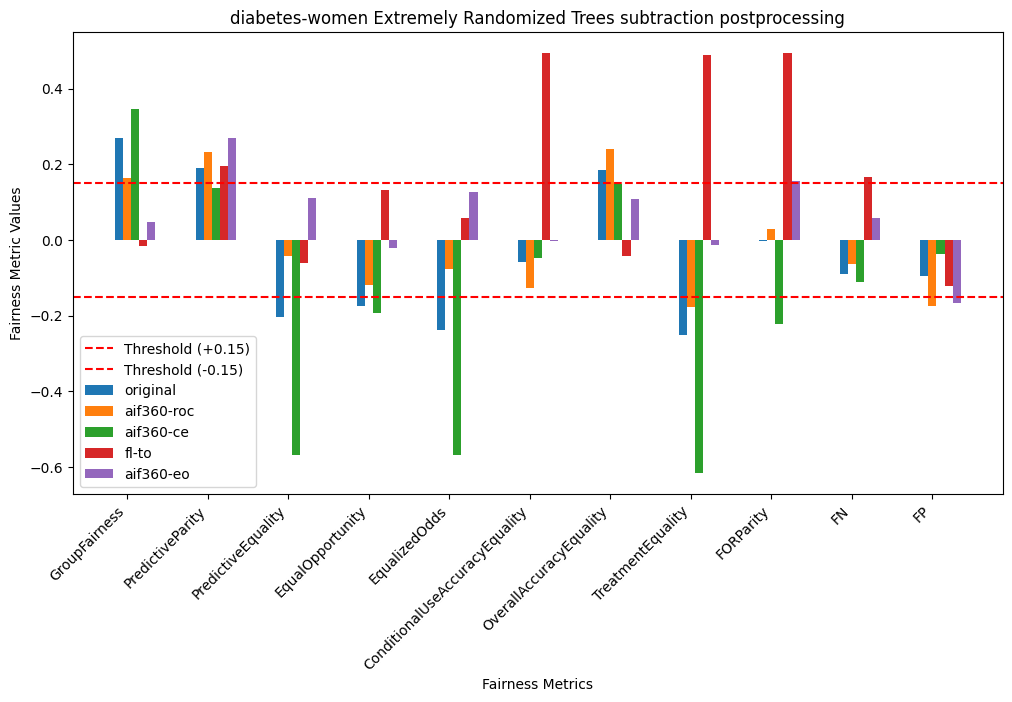

Ada Boost
[[0.27090493681748073, 0.20989619255400838, -0.22555041449778296, -0.20229392857968373, -0.2789234303707988, 0.08051876486087013, 0.18354185189566402, 0.05626984126984128, 0.09233677141571876, -0.09060021681200661, -0.09294163508365742], [0.24024151160540191, 0.20608026919861136, -0.23221491228070174, -0.16799359441092848, -0.27070175438596494, 0.09360416816299169, 0.18001406881922732, 0.052103174603174596, 0.17183328797105885, -0.07350461266774885, -0.10650945615147848], [0.3679067350664658, 0.16804852170247617, -0.4453123192596877, -0.2598394268774703, -0.4453123192596877, 0.012241807716709917, 0.1743880930374791, -0.6877777777777778, -0.17251511130768096, -0.13452423650740666, -0.039863856530072427], [-0.08553049059545093, 0.2158622458068919, 0.1810222672064777, 0.17161157381266076, 0.32205401323822375, 0.381572907544438, -0.08969254633830978, 0.1638888888888889, 0.38157290754443807, 0.22423469601144613, -0.13454214967313635], [0.04608207913697115, 0.2593739148889465, 0.09

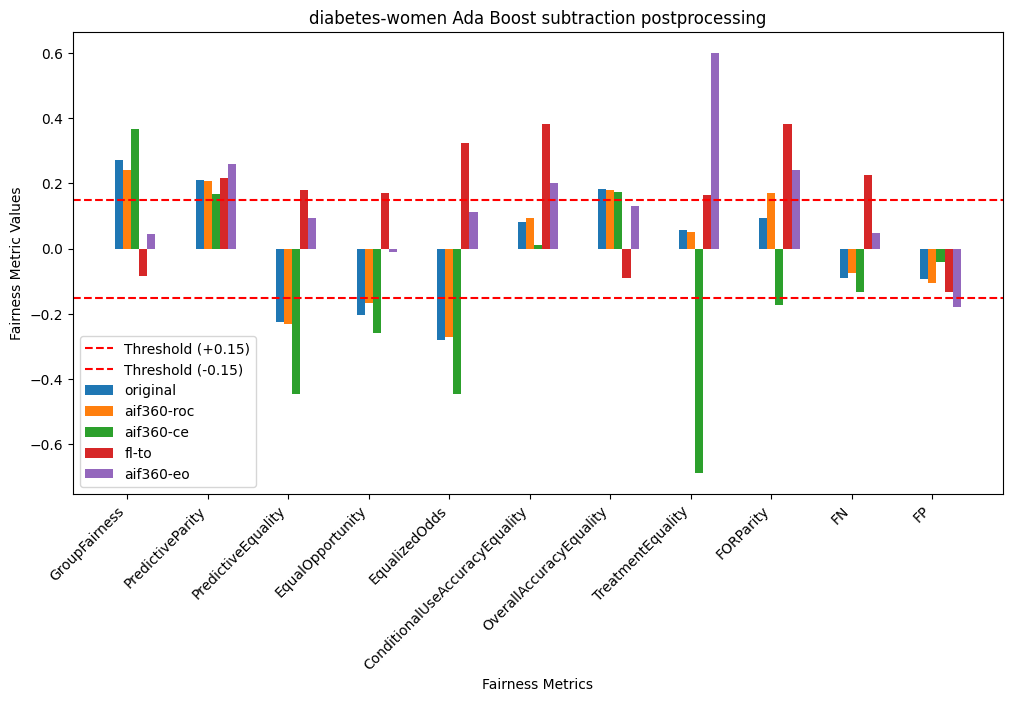

In [23]:
for m in models:
  print(m)
  grouped_bar(postprocessing_metrics["diabetes-women"], postprocessing_mitigation_list, "subtraction", m, 'postprocessing')

# Extra


## PCA alternative plot, with baseline evidenced.

<ipython-input-18-f320214433c2>:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, row_df], ignore_index=True)


Distance between fl-cr and original: 0.06764902762829166
Distance between aif360-rw and original: 1.8508624683192079
Distance between aif360-di and original: 0.10457017222309328
Distance between aif360-lfr and original: 2.8149879055630516
Distance between aif360-op and original: 2.354348898589326


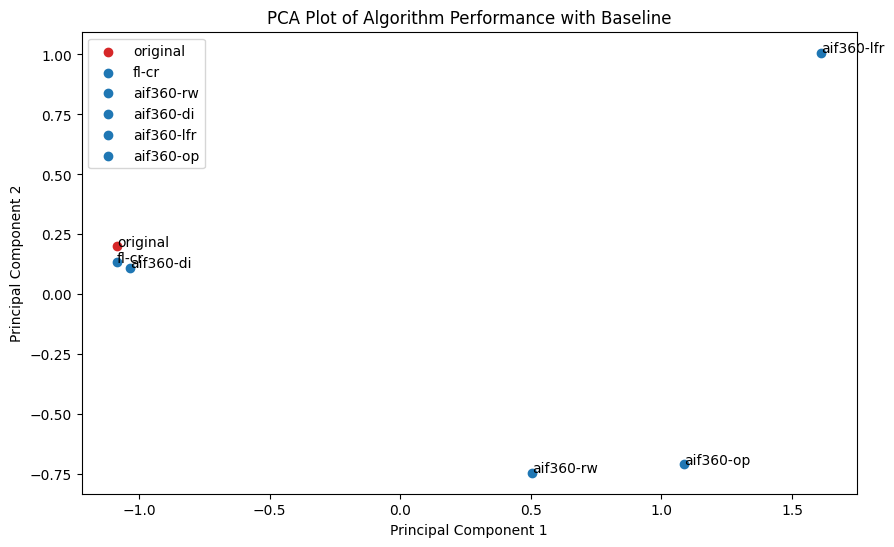

In [28]:
# Load the data
data = data_framing(overall_metrics, 'diabetes-women', "division", "Logistic Regression")

pca = PCA(n_components=2)
principal_components = pca.fit_transform(data)

# Select a baseline
baseline_algorithm = 'original'
baseline_index = data.index.get_loc(baseline_algorithm)

# Create a scatter plot
plt.figure(figsize=(10, 6))

for i, algorithm in enumerate(data.index):
    if algorithm == baseline_algorithm:
        plt.scatter(principal_components[i, 0], principal_components[i, 1], c='tab:red', label=algorithm)
    else:
        plt.scatter(principal_components[i, 0], principal_components[i, 1], c='tab:blue', label=algorithm)

# Annotate points with names
for i, algorithm in enumerate(data.index):
    plt.annotate(algorithm, (principal_components[i, 0], principal_components[i, 1]))

# Add labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot of Algorithm Performance with Baseline')

# Add legend
plt.legend()

# TO DO: Distances should be calculated before the PCA
for i, algorithm in enumerate(data.index):
    if algorithm != baseline_algorithm:
        distance = euclidean(principal_components[i], principal_components[baseline_index])
        print(f"Distance between {algorithm} and {baseline_algorithm}: {distance}")

plt.show()

T-SNE experiment alternative to PCA.

In [29]:
tsne = TSNE(n_components=2, perplexity=3)
X_r = tsne.fit_transform(vectorise(overall_metrics, 'diabetes-women', "division", "Logistic Regression"))

fig = plt.figure()
ax = fig.add_subplot(111)
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']#,'tab:cyan']
ax.scatter(X_r[:, 0], X_r[:, 1], color=colors)
for i, label in enumerate(mitigation_list):
    plt.annotate(label, (X_r[:, 0][i], X_r[:, 1][i]))
plt.show()

NameError: name 'vectorise' is not defined

## Heatmaps

In [ ]:
# Aggregation of metrics
def aggregate_all(metrics_dictionary, dataset, mitigation, comparison, model):
  l = []
  for metric in metrics:
    l.append(metrics_dictionary[dataset][mitigation][comparison][model][metric]["Value"])
  return np.mean(l), np.std(l)

In [ ]:
# TO DO questo richiede chiaramente che le misure vengano in qualche modo normalizzate o stiano tutte entro lo stesso intervallo e con significati quantitativi simili -> DIFFICILE
aggregate_all(overall_metrics, 'diabetes-women', 'original', "division", "Logistic Regression")

In [ ]:
# Aggregation of metrics by family
def fine_aggregation(metrics_dictionary, dataset, mitigation, comparison, model):
  groups = {'metrics_on_results': ['GroupFairness'],
            'metrics_on_FP': ['PredictiveParity', 'PredictiveEquality', 'FP'],
            'metrics_on_FN': ['EqualOpportunity', 'FORParity', 'FN'],
            'metrics_on_all': ['TreatmentEquality', 'EqualizedOdds', 'ConditionalUseAccuracyEquality', 'OverallAccuracyEquality']
            }

  aggregated_metrics = {}
  for k in groups.keys():
    support = []
    for metric in groups[k]:
      support.append(metrics_dictionary[dataset][mitigation][comparison][model][metric]["Value"])
    aggregated_metrics[k] = np.array([np.mean(support), np.std(support)])

  return aggregated_metrics

In [ ]:
fine_aggregation(overall_metrics, 'diabetes-women', 'original', "division", "Logistic Regression")

In [ ]:
sns.set()
for model in models:
  plt.figure(figsize=(10, 5))
  ax = sns.heatmap(data_framing(overall_metrics, 'diabetes-women', "division", model), annot=True)
  plt.title("Heatmap Fairness Metrics - {}".format(model))
  plt.show()